In [1]:
%matplotlib inline

In [2]:
account_number=Enter Your Key
password=Enter Your Key
server=Enter Your Key

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import streamlit as st
from datetime import datetime
import matplotlib.pyplot as plt
import time

mt5.initialize()
mt5.login(account_number, password=password, server=server)

True

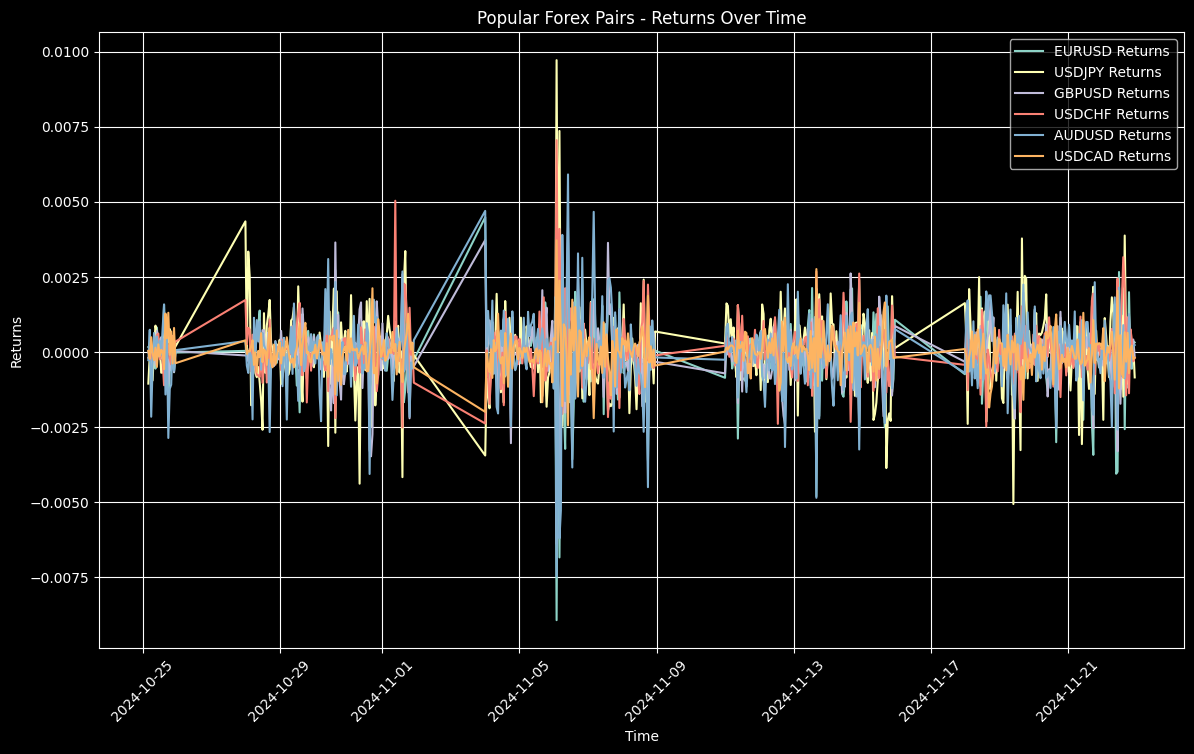

In [4]:
# Initialize MT5
if not mt5.initialize():
    print("Failed to initialize MetaTrader5")
else:
    # Define the Forex pairs
    forex_pairs = ["EURUSD", "USDJPY", "GBPUSD", "USDCHF", "AUDUSD", "USDCAD"]

    # Dictionary to store dataframes for each pair
    forex_data = {}

    # Pull historical data for each pair
    for pair in forex_pairs:
        rates = mt5.copy_rates_from_pos(pair, mt5.TIMEFRAME_H1, 0, 500)  # Last 500 hours of data
        df = pd.DataFrame(rates)
        df['time'] = pd.to_datetime(df['time'], unit='s')  # Convert Unix timestamp to datetime
        df['returns'] = df['close'].pct_change()  # Calculate returns as percentage change
        forex_data[pair] = df

    # Shut down MT5 after data retrieval
    mt5.shutdown()

# Plotting the returns
plt.style.use('dark_background')
plt.figure(figsize=(14, 8))

# Plot each forex pair's returns
for pair, data in forex_data.items():
    plt.plot(data['time'], data['returns'], label=f'{pair} Returns')

# Customize the plot
plt.title('Popular Forex Pairs - Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.show()

In [5]:
import pandas as pd

# Consolidate all Forex data into a single DataFrame with 'pair' as an identifier
all_data = []
for pair, data in forex_data.items():
    data['pair'] = pair  # Add a column to identify the pair
    data['returns'] = data['close'].pct_change()  # Calculate returns
    all_data.append(data)

# Combine into a single DataFrame
df = pd.concat(all_data)

In [6]:
df

time     open     high      low    close  tick_volume  \
0   2024-10-25 03:00:00  1.08239  1.08249  1.08200  1.08216         1040   
1   2024-10-25 04:00:00  1.08217  1.08248  1.08200  1.08234         1003   
2   2024-10-25 05:00:00  1.08233  1.08274  1.08227  1.08258          825   
3   2024-10-25 06:00:00  1.08258  1.08258  1.08201  1.08216          610   
4   2024-10-25 07:00:00  1.08217  1.08230  1.08205  1.08218          637   
..                  ...      ...      ...      ...      ...          ...   
495 2024-11-22 19:00:00  1.39862  1.39862  1.39759  1.39764         1833   
496 2024-11-22 20:00:00  1.39766  1.39799  1.39709  1.39776         1525   
497 2024-11-22 21:00:00  1.39777  1.39814  1.39766  1.39806         1463   
498 2024-11-22 22:00:00  1.39806  1.39878  1.39761  1.39773         1373   
499 2024-11-22 23:00:00  1.39774  1.39828  1.39742  1.39746         1209   

     spread  real_volume   returns    pair  
0         3            0       NaN  EURUSD  
1         4            0  0.000166  EURUSD  
2         0            0  0.000222  EURUSD  
3         1            0 -0.000388  EURUSD  
4         0            0  0.000018  EURUSD  
..      ...          ...       ...     ...  
495       5            0 -0.000708  USDCAD  
496       6            0  0.000086  USDCAD  
497       6            0  0.000215  USDCAD  
498       6            0 -0.000236  USDCAD  
499       3            0 -0.000193  USDCAD  

[3000 rows x 10 columns]

In [7]:
# Calculate rolling volatility (standard deviation of returns) for each pair
df['volatility'] = df.groupby('pair')['returns'].transform(lambda x: x.rolling(window=20).std())

In [8]:
# Calculate short-term (e.g., 50-period) and long-term (e.g., 200-period) moving averages for trend analysis
df['MA_50'] = df.groupby('pair')['close'].transform(lambda x: x.rolling(window=50).mean())
df['MA_200'] = df.groupby('pair')['close'].transform(lambda x: x.rolling(window=200).mean())

# Define trend direction based on moving average crossovers
df['trend'] = df['MA_50'] > df['MA_200']  # Bullish trend if 50-MA is above 200-MA

In [9]:
# Set up columns for signals
df['Buy_Signal'] = False
df['Sell_Signal'] = False

# Generate signals for a trend-following strategy
for pair in df['pair'].unique():
    pair_data = df[df['pair'] == pair]
    df.loc[pair_data.index, 'Buy_Signal'] = (pair_data['MA_50'] > pair_data['MA_200']) & (pair_data['MA_50'].shift() <= pair_data['MA_200'].shift())
    df.loc[pair_data.index, 'Sell_Signal'] = (pair_data['MA_50'] < pair_data['MA_200']) & (pair_data['MA_50'].shift() >= pair_data['MA_200'].shift())

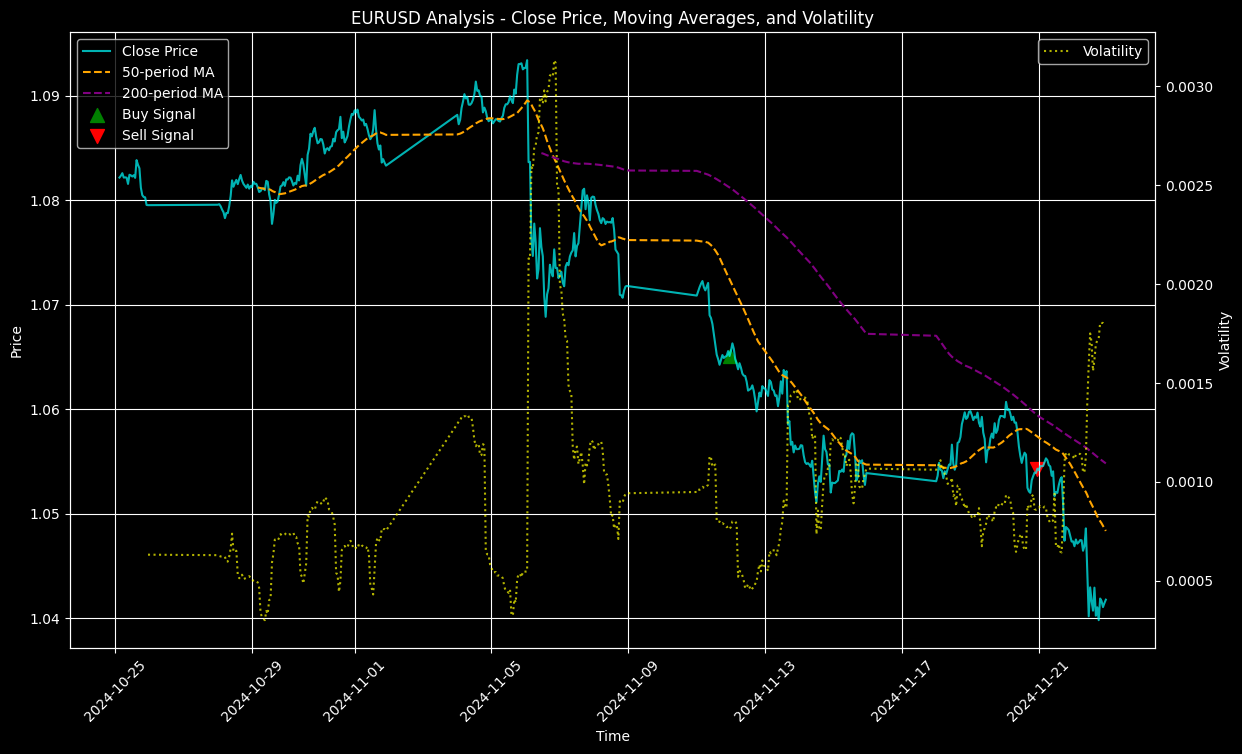

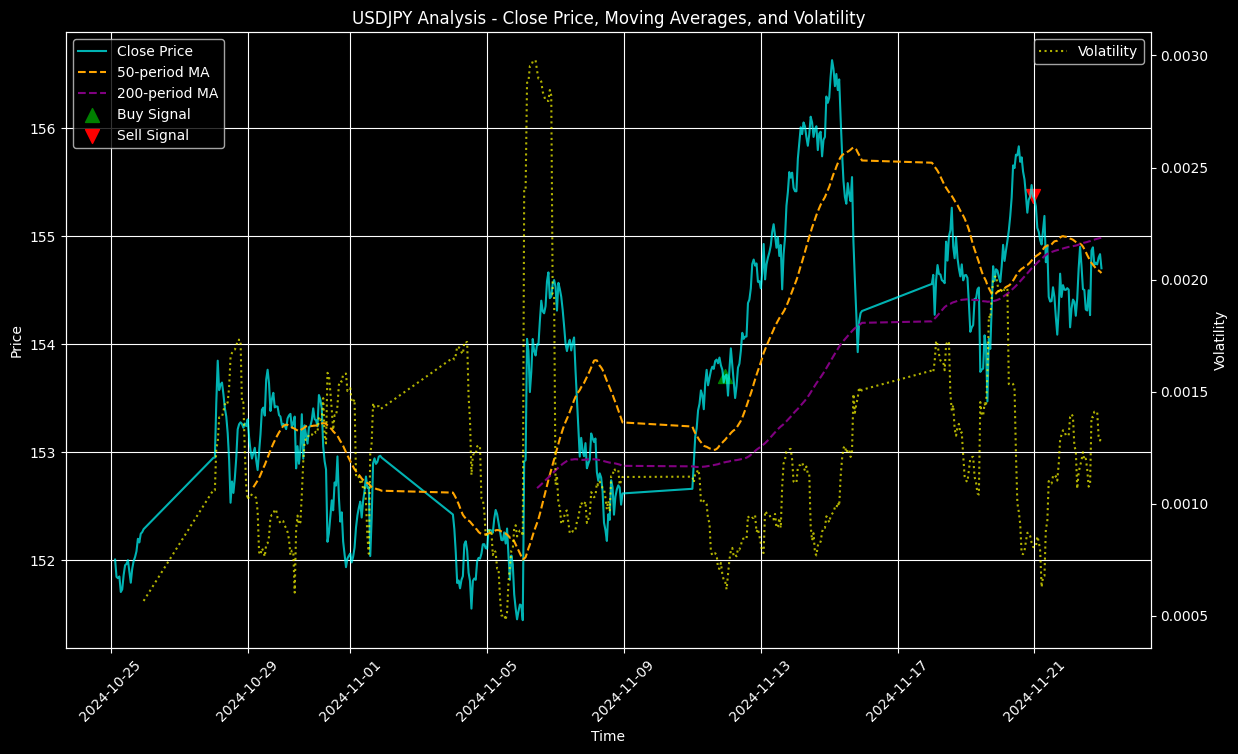

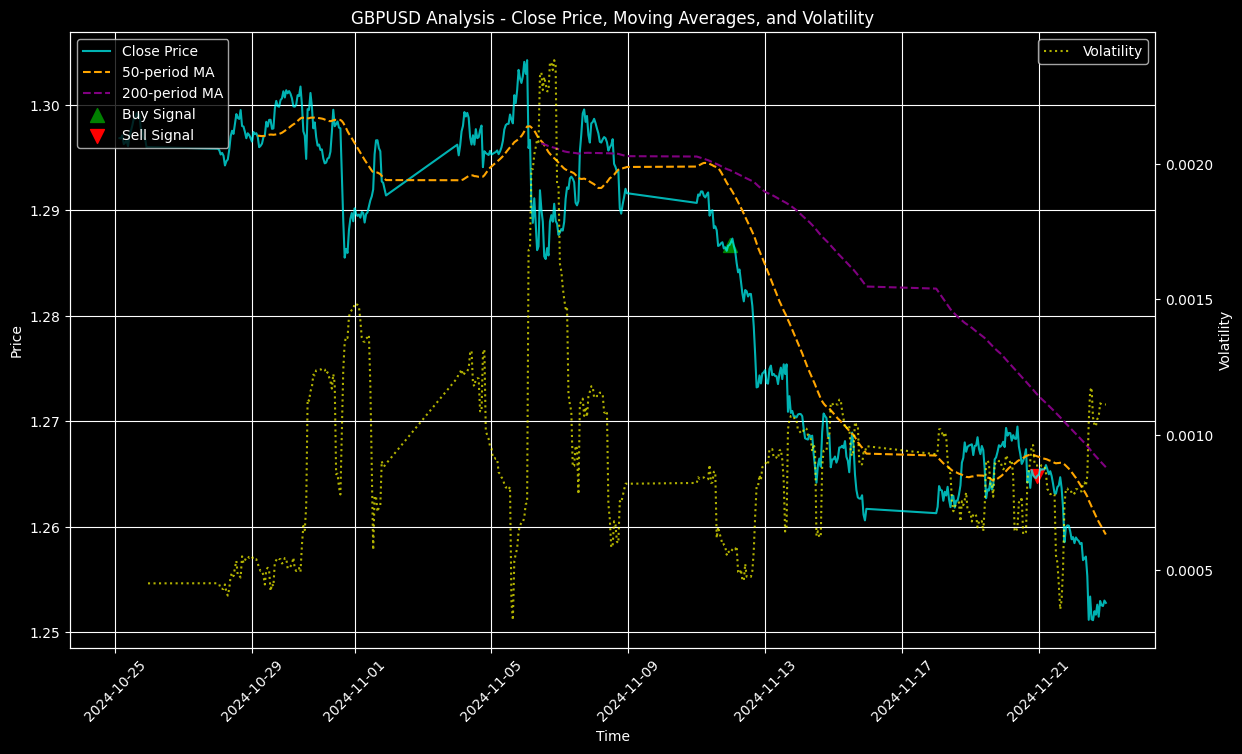

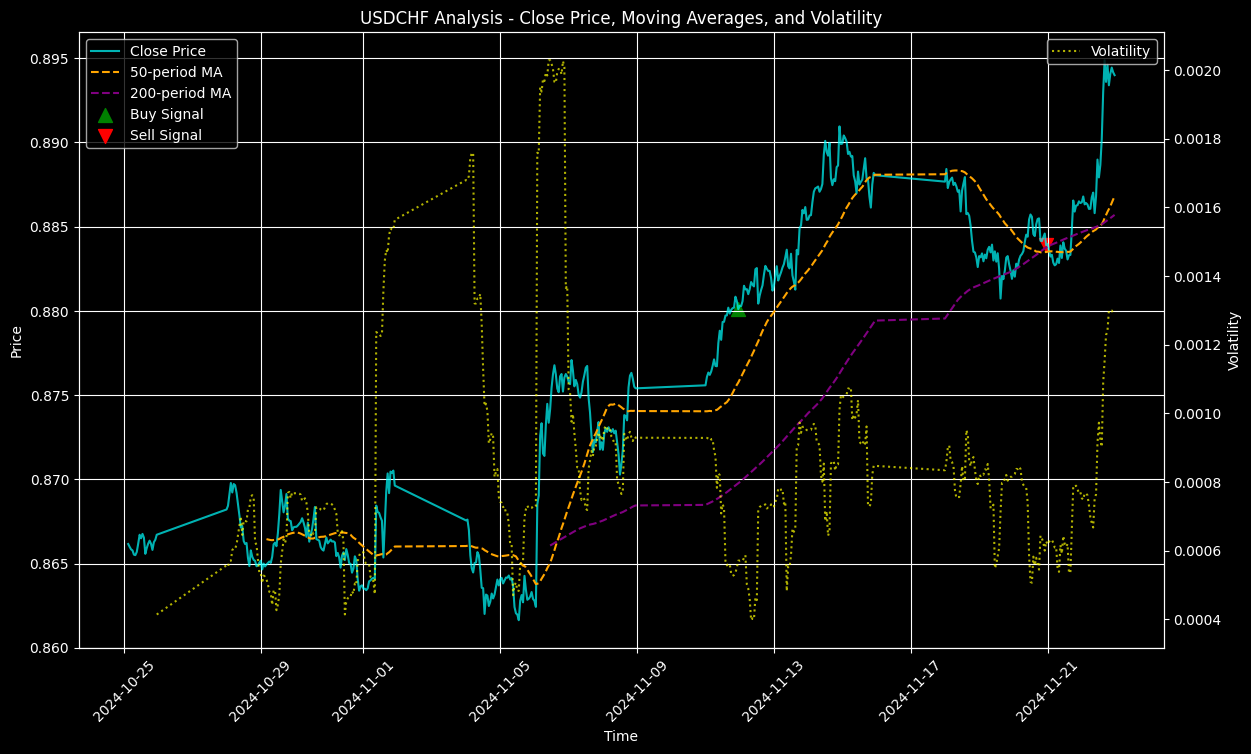

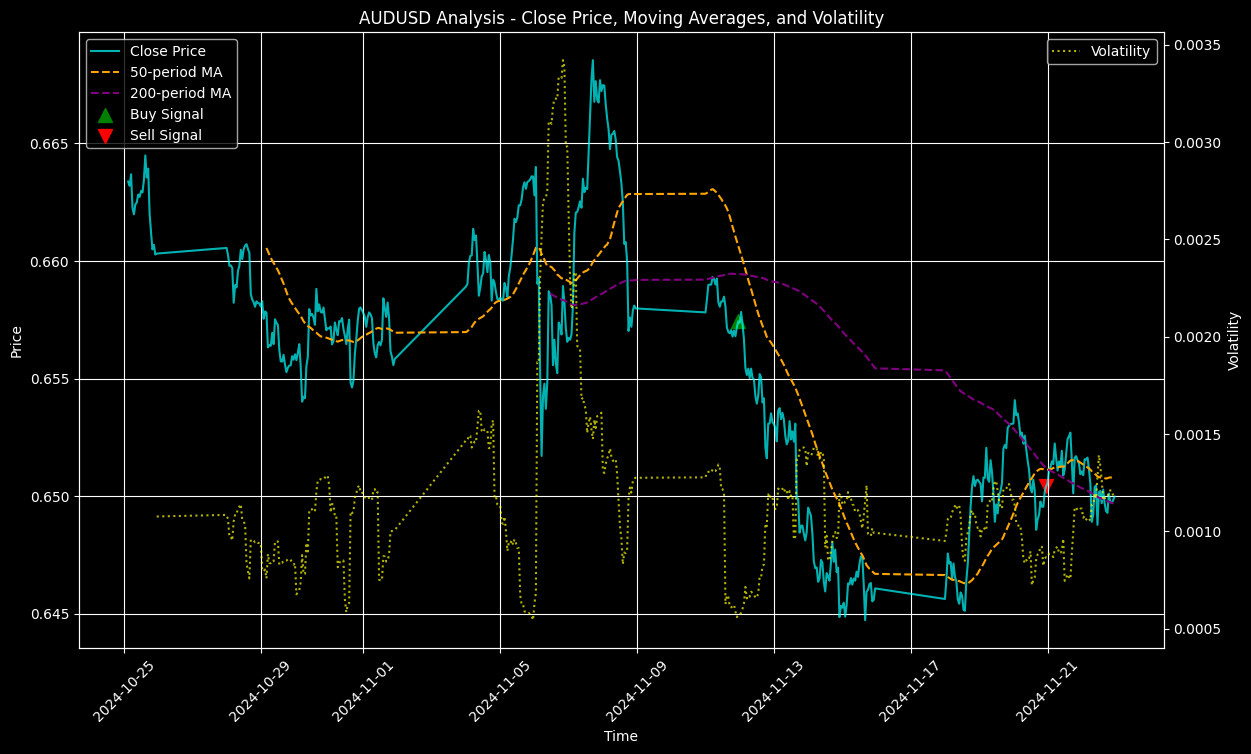

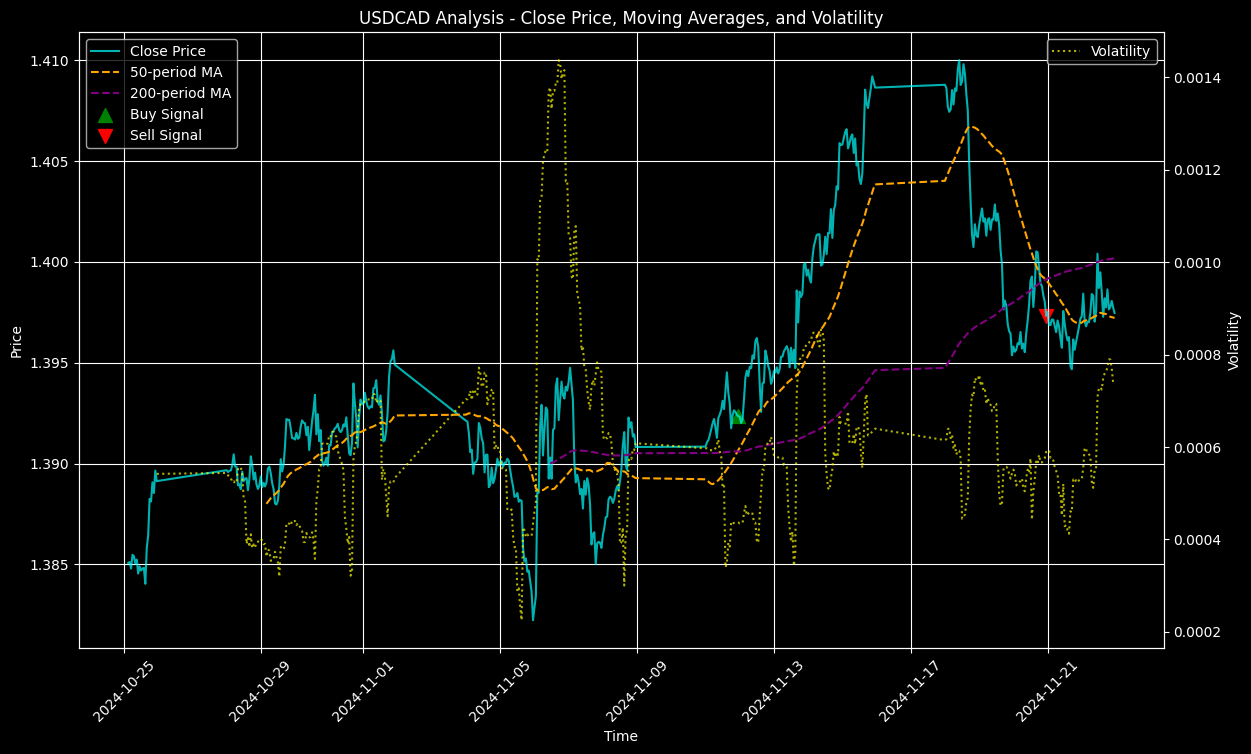

In [10]:
import matplotlib.pyplot as plt

# Define function to plot each Forex pair with the specified indicators and signals
def plot_forex_analysis(df, pair):
    pair_data = df[df['pair'] == pair]

    # Set up the plot with a black background
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot close price
    ax1.plot(pair_data['time'], pair_data['close'], label='Close Price', color='cyan', alpha=0.7)
    
    # Plot moving averages
    ax1.plot(pair_data['time'], pair_data['MA_50'], label='50-period MA', color='orange', linestyle='--')
    ax1.plot(pair_data['time'], pair_data['MA_200'], label='200-period MA', color='purple', linestyle='--')

    # Mark Buy and Sell signals
    buy_signals = pair_data[pair_data['Buy_Signal']]
    sell_signals = pair_data[pair_data['Sell_Signal']]
    ax1.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    ax1.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    # Plot historical volatility on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(pair_data['time'], pair_data['volatility'], label='Volatility', color='yellow', linestyle=':', alpha=0.7)
    ax2.set_ylabel('Volatility')

    # Customize the plot
    ax1.set_title(f'{pair} Analysis - Close Price, Moving Averages, and Volatility')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    ax1.xaxis.set_tick_params(rotation=45)

    plt.show()

# Plot analysis for each Forex pair
for pair in df['pair'].unique():
    plot_forex_analysis(df, pair)

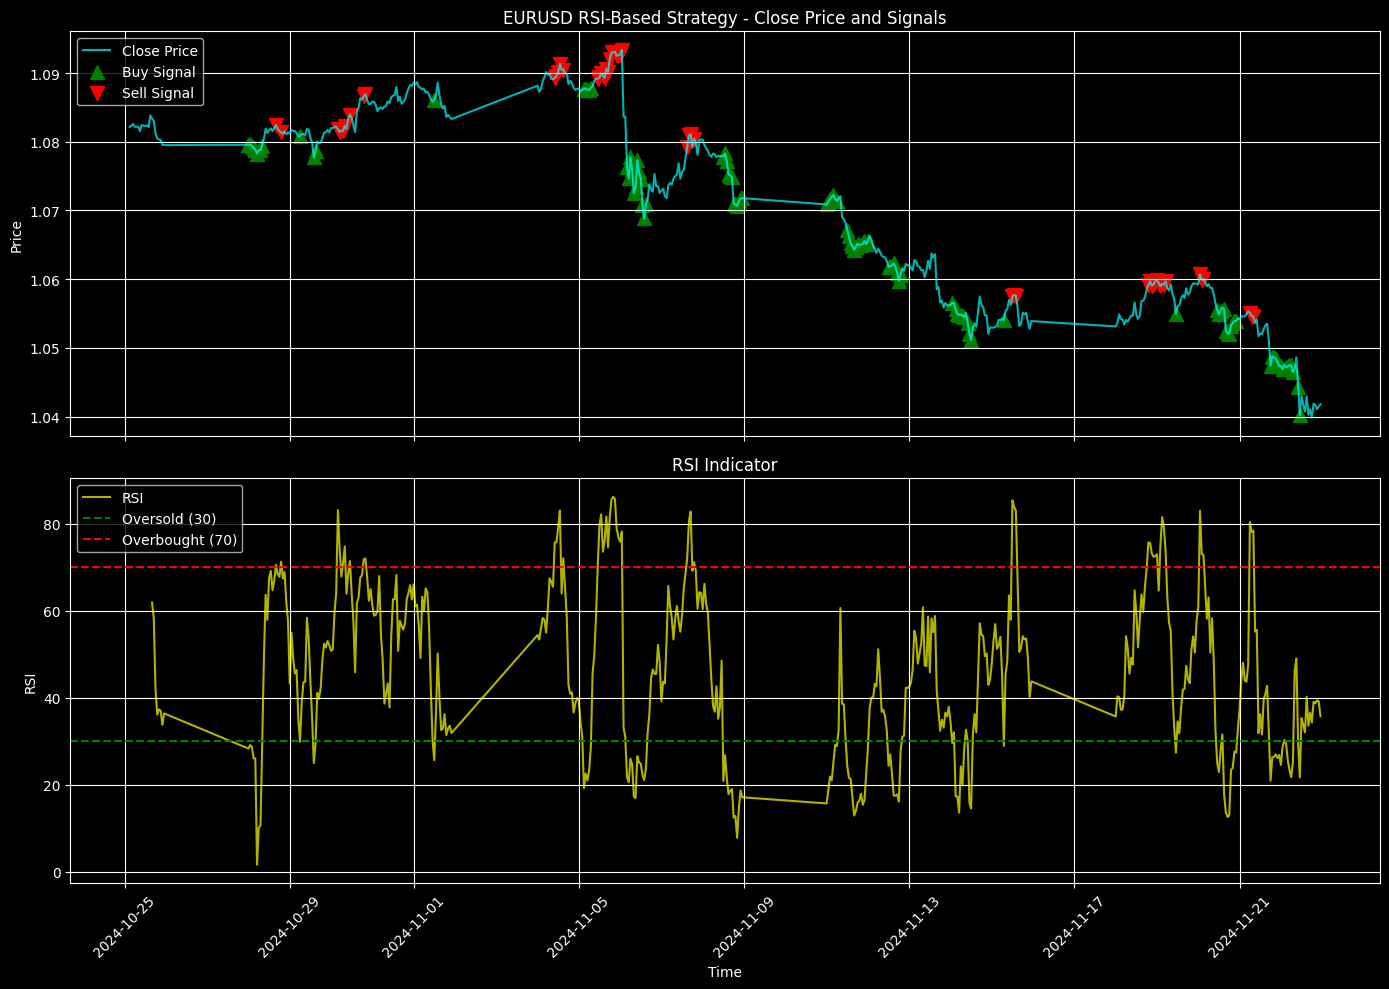

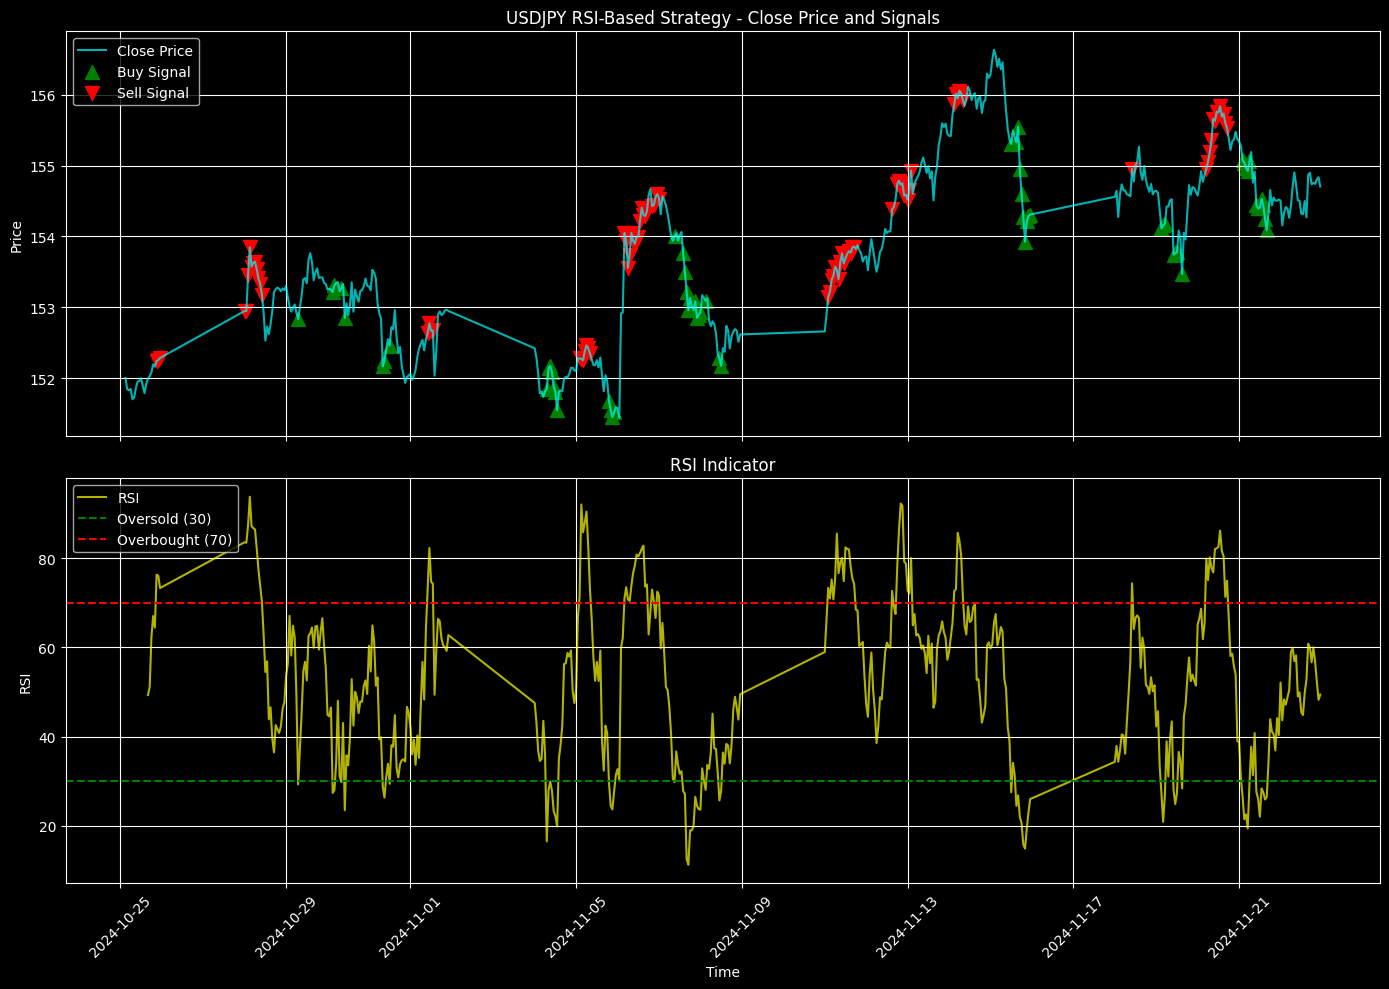

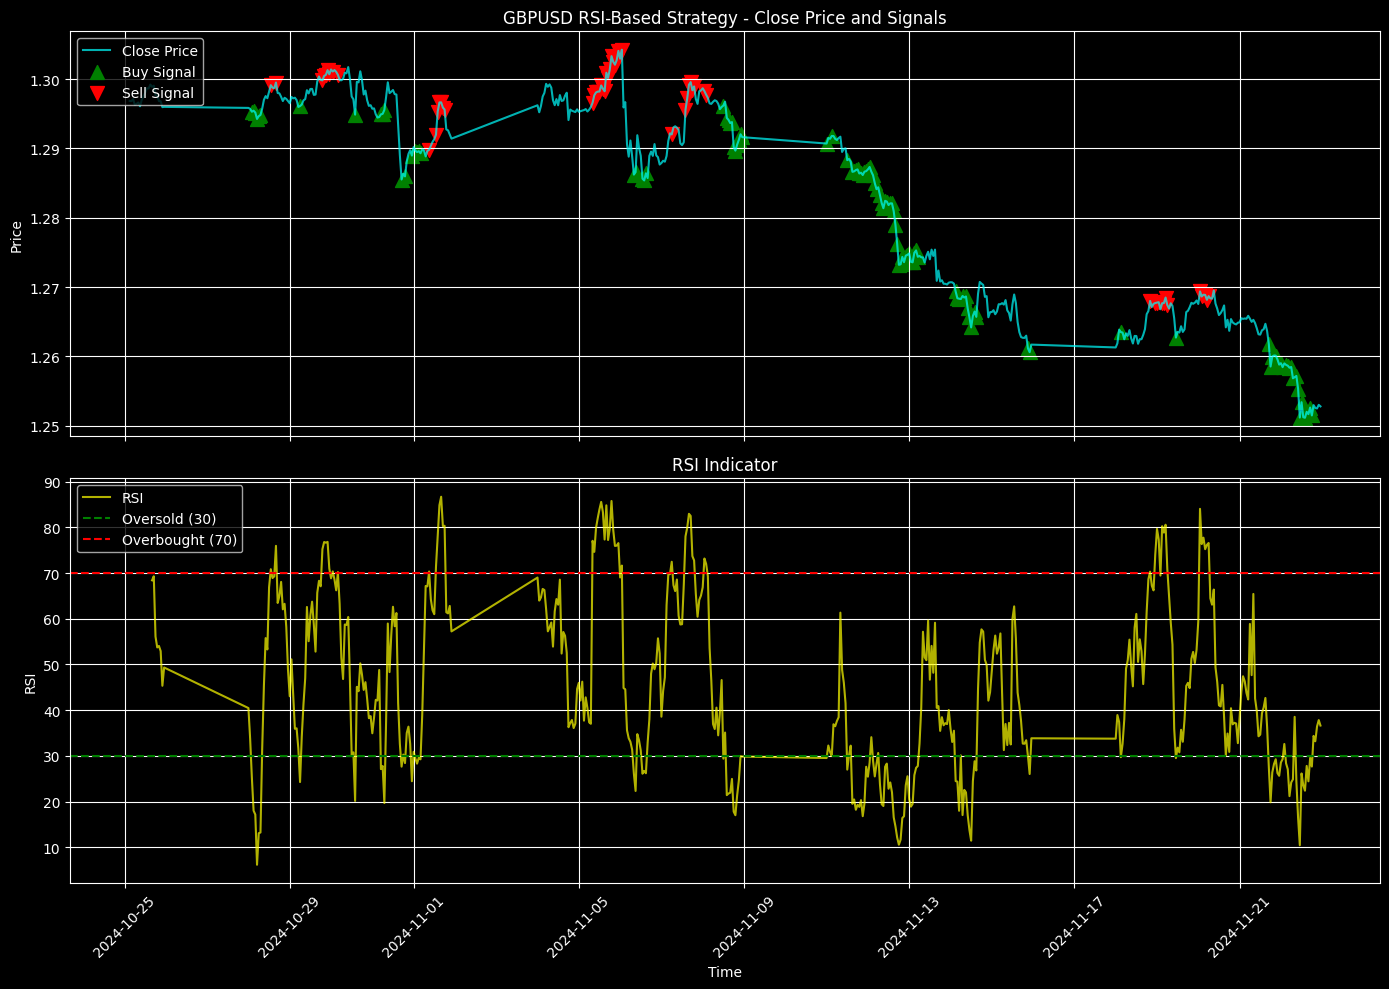

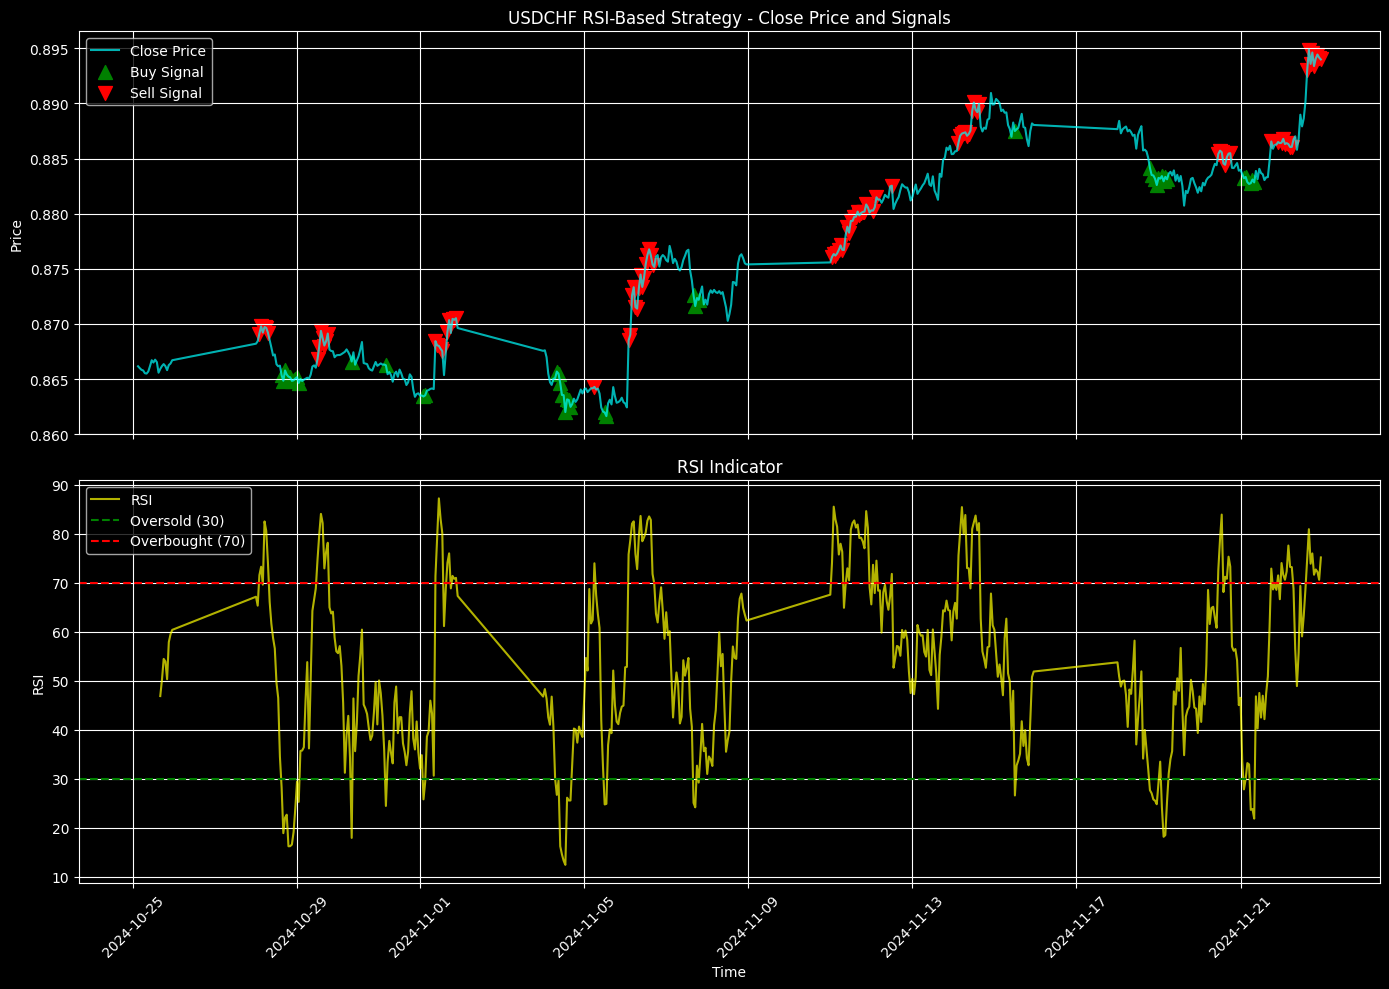

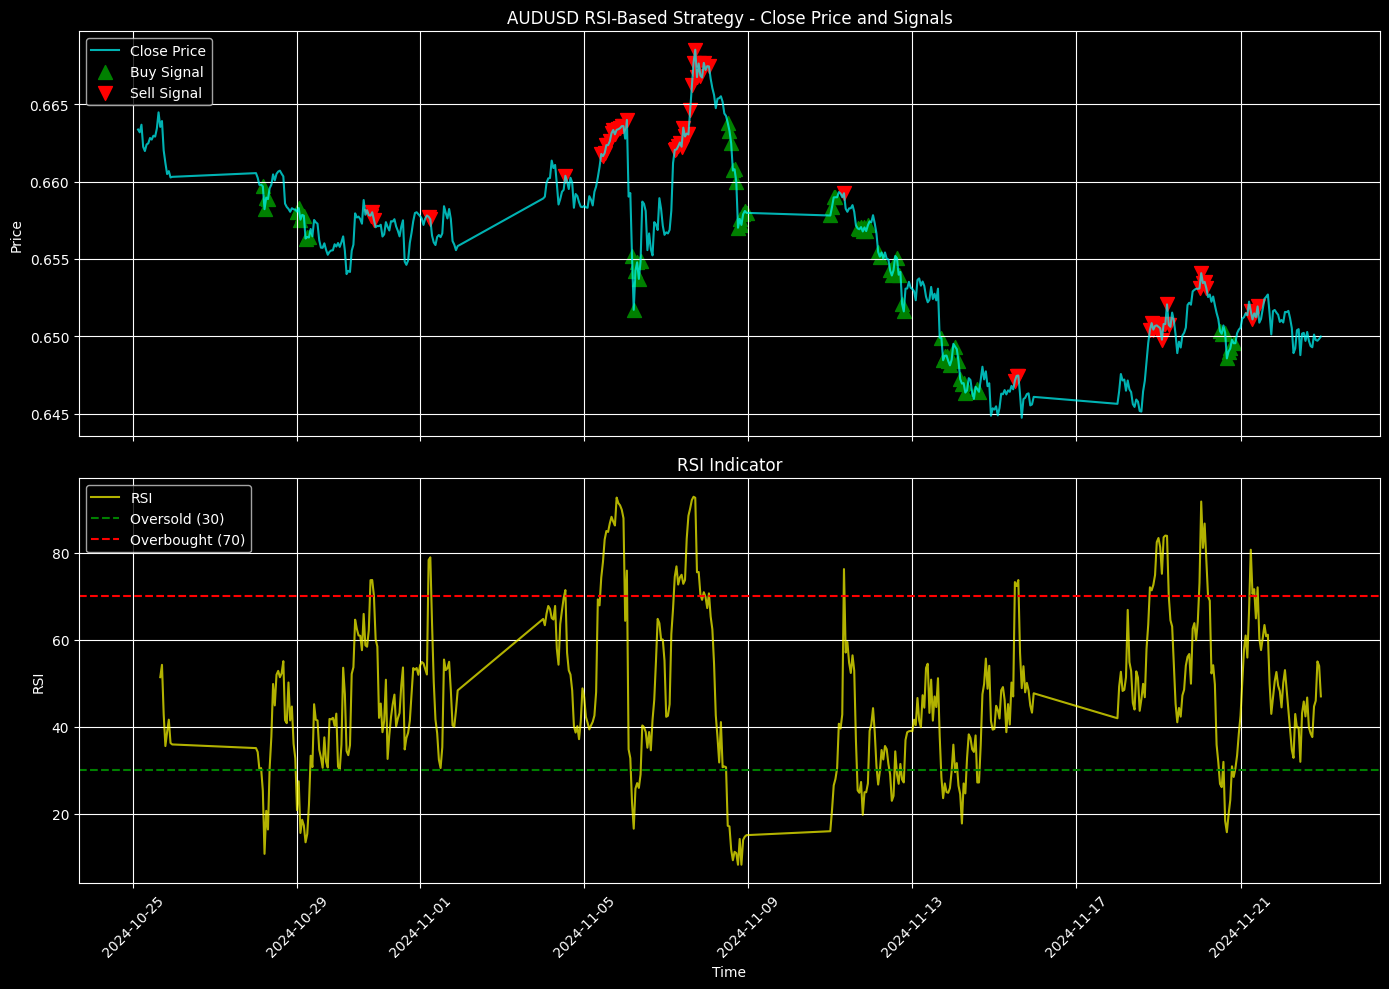

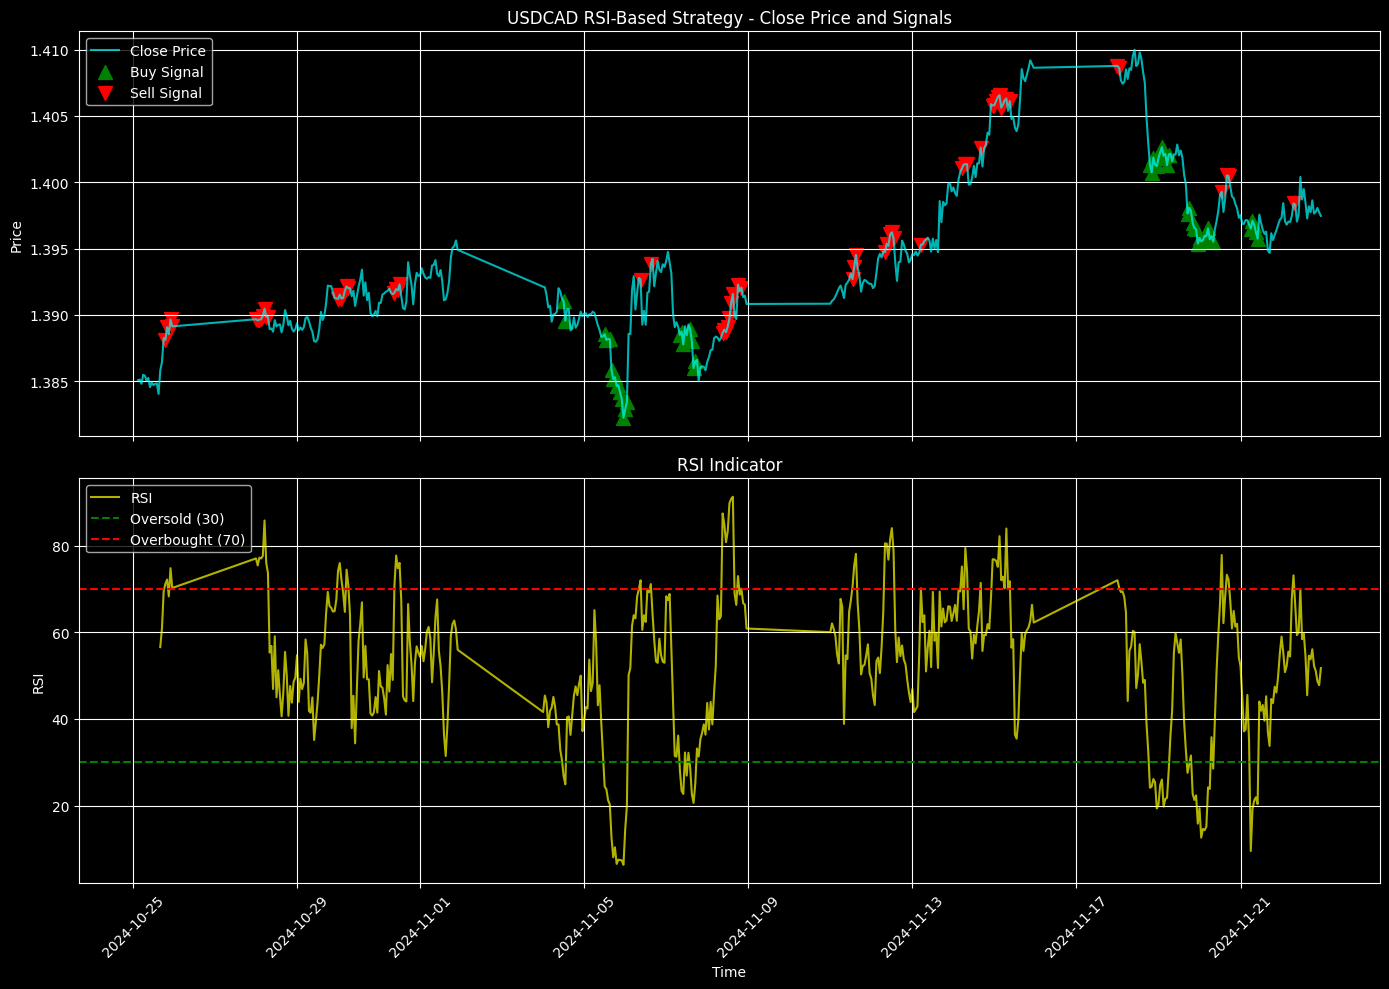

In [11]:
import numpy as np

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI and set buy/sell signals based on RSI thresholds
for pair, data in forex_data.items():
    data['RSI'] = calculate_rsi(data)
    data['Buy_Signal'] = data['RSI'] < 30   # Buy when RSI is below 30 (oversold)
    data['Sell_Signal'] = data['RSI'] > 70  # Sell when RSI is above 70 (overbought)

# Function to plot each Forex pair with RSI-based signals
def plot_rsi_analysis(df, pair):
    pair_data = df[df['pair'] == pair]

    # Set up the plot with a black background
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot close price with buy and sell signals
    ax1.plot(pair_data['time'], pair_data['close'], label='Close Price', color='cyan', alpha=0.7)
    buy_signals = pair_data[pair_data['Buy_Signal']]
    sell_signals = pair_data[pair_data['Sell_Signal']]
    ax1.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    ax1.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    # Customize the price plot
    ax1.set_title(f'{pair} RSI-Based Strategy - Close Price and Signals')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot RSI on a secondary axis
    ax2.plot(pair_data['time'], pair_data['RSI'], label='RSI', color='yellow', alpha=0.7)
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    
    # Customize the RSI plot
    ax2.set_title('RSI Indicator')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Consolidate the data into a single DataFrame for plotting
all_data = []
for pair, data in forex_data.items():
    data['pair'] = pair  # Add pair identifier
    all_data.append(data)
df = pd.concat(all_data, ignore_index=True)

# Plot RSI-based strategy for each Forex pair
for pair in df['pair'].unique():
    plot_rsi_analysis(df, pair)


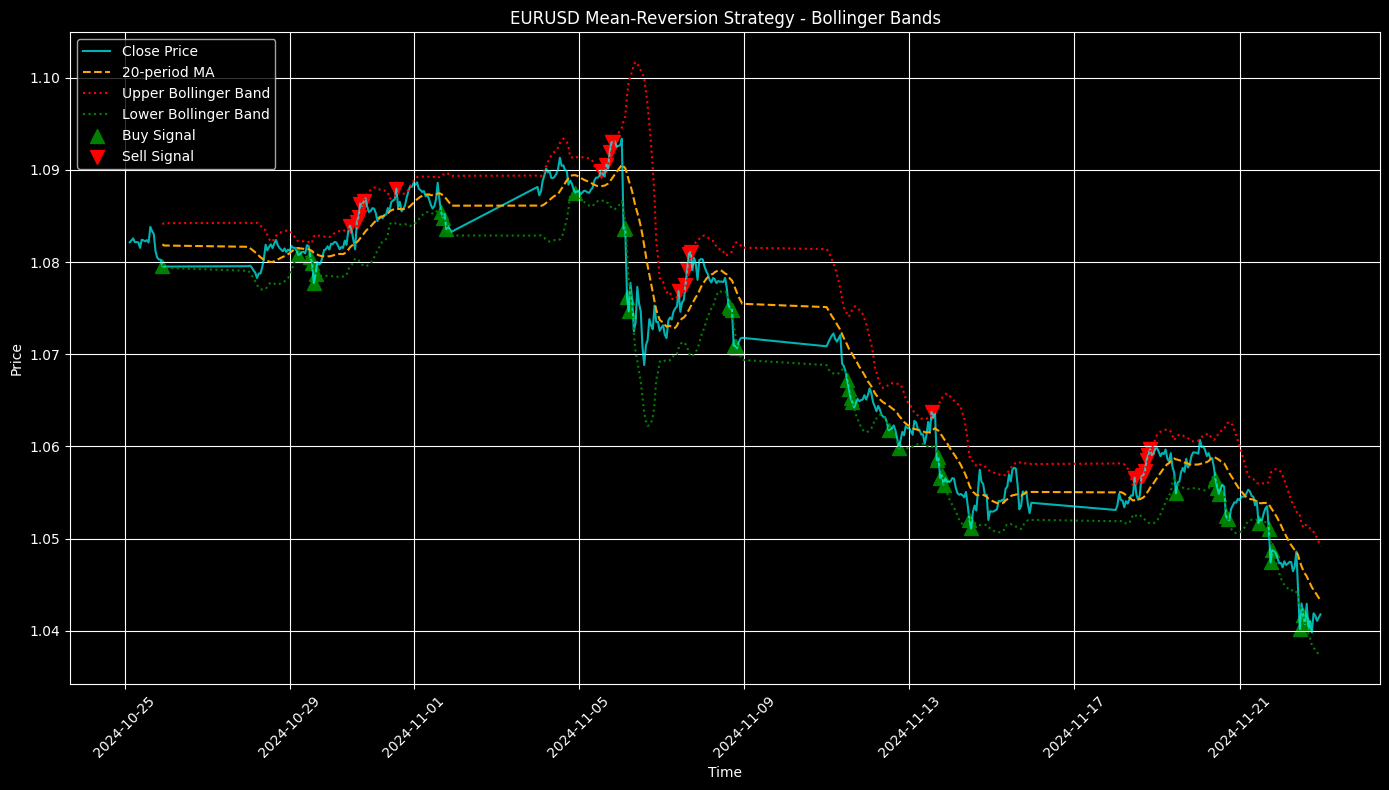

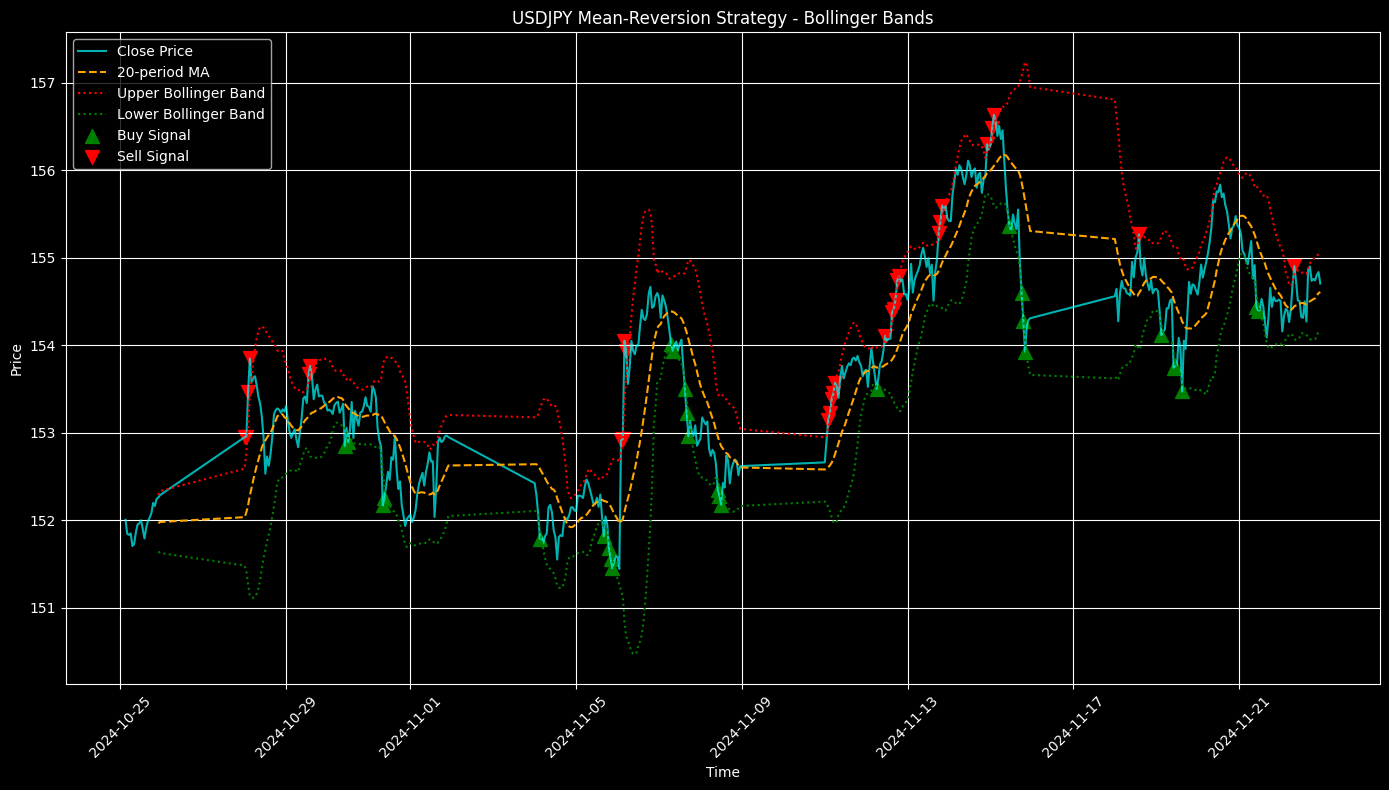

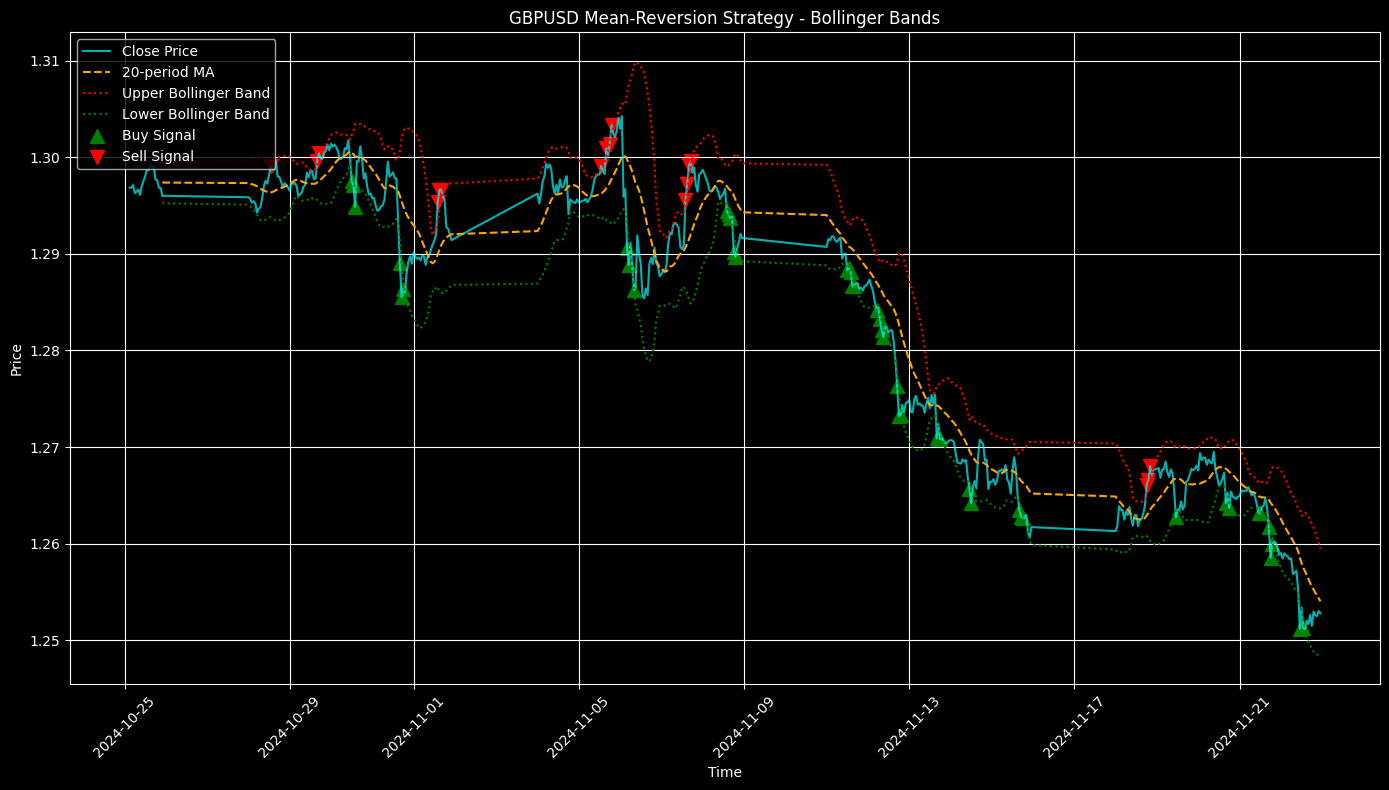

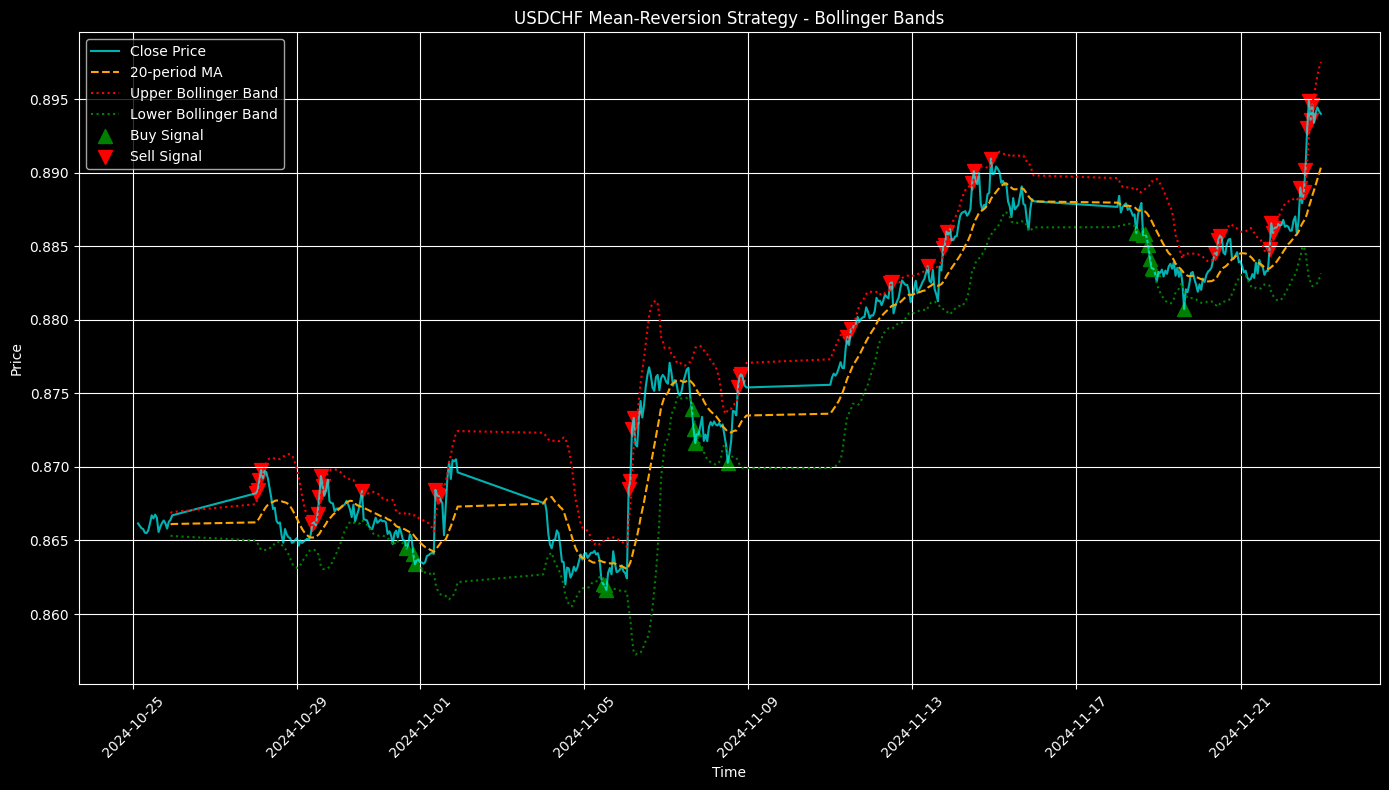

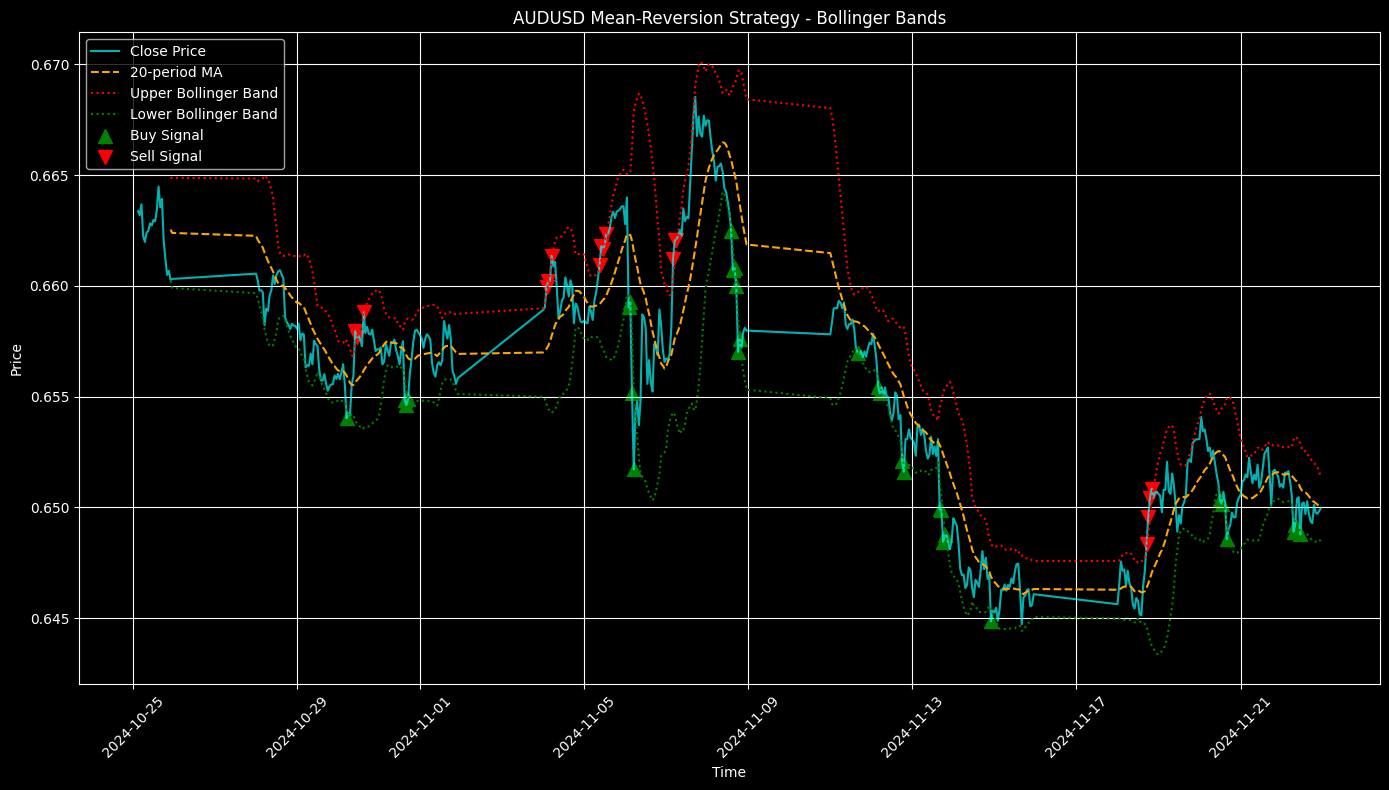

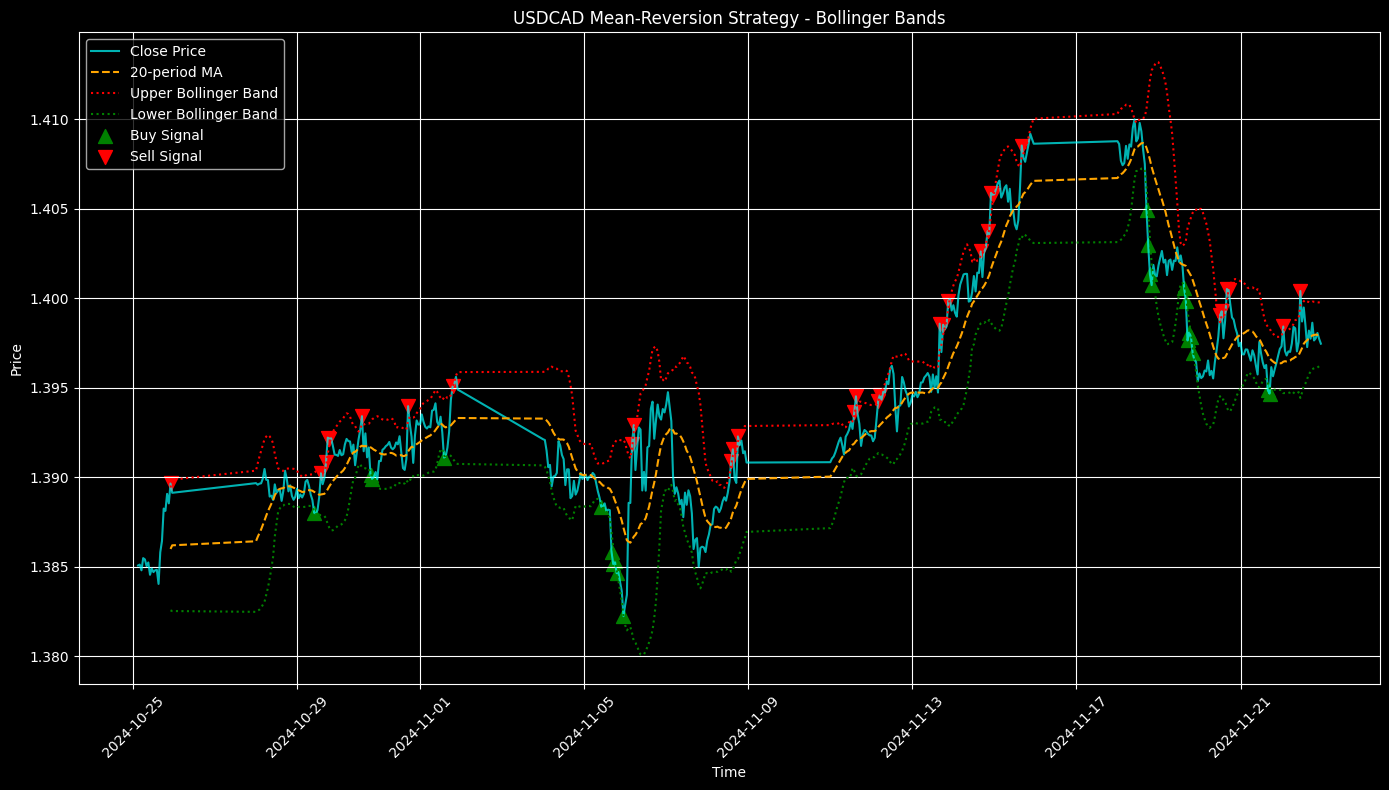

In [12]:
# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, period=20, std_dev=2):
    data['MA'] = data['close'].rolling(window=period).mean()  # Moving Average
    data['Upper_Band'] = data['MA'] + (data['close'].rolling(window=period).std() * std_dev)
    data['Lower_Band'] = data['MA'] - (data['close'].rolling(window=period).std() * std_dev)
    return data

# Set up the mean-reversion strategy with Bollinger Bands
for pair, data in forex_data.items():
    data = calculate_bollinger_bands(data)
    data['Buy_Signal'] = data['close'] < data['Lower_Band']  # Buy when price is below lower band
    data['Sell_Signal'] = data['close'] > data['Upper_Band']  # Sell when price is above upper band

# Function to plot each Forex pair with mean-reversion signals
def plot_mean_reversion(df, pair):
    pair_data = df[df['pair'] == pair]

    # Set up the plot with a black background
    plt.style.use('dark_background')
    plt.figure(figsize=(14, 8))

    # Plot close price and moving average
    plt.plot(pair_data['time'], pair_data['close'], label='Close Price', color='cyan', alpha=0.7)
    plt.plot(pair_data['time'], pair_data['MA'], label='20-period MA', color='orange', linestyle='--')

    # Plot Bollinger Bands
    plt.plot(pair_data['time'], pair_data['Upper_Band'], label='Upper Bollinger Band', color='red', linestyle=':')
    plt.plot(pair_data['time'], pair_data['Lower_Band'], label='Lower Bollinger Band', color='green', linestyle=':')

    # Mark Buy and Sell signals
    buy_signals = pair_data[pair_data['Buy_Signal']]
    sell_signals = pair_data[pair_data['Sell_Signal']]
    plt.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    # Customize the plot
    plt.title(f'{pair} Mean-Reversion Strategy - Bollinger Bands')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Consolidate the data into a single DataFrame for plotting
all_data = []
for pair, data in forex_data.items():
    data['pair'] = pair  # Add pair identifier
    all_data.append(data)
df = pd.concat(all_data, ignore_index=True)

# Plot mean-reversion strategy for each Forex pair
for pair in df['pair'].unique():
    plot_mean_reversion(df, pair)

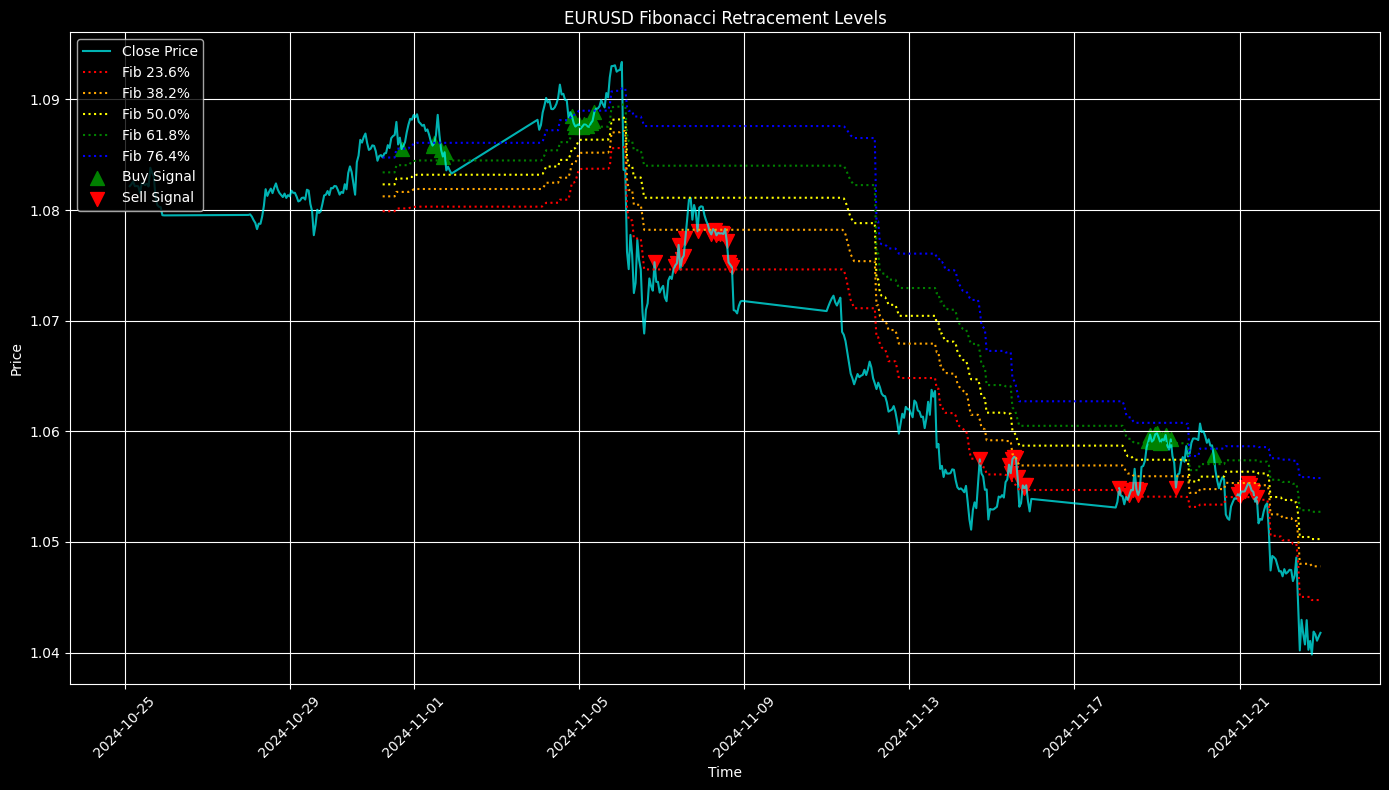

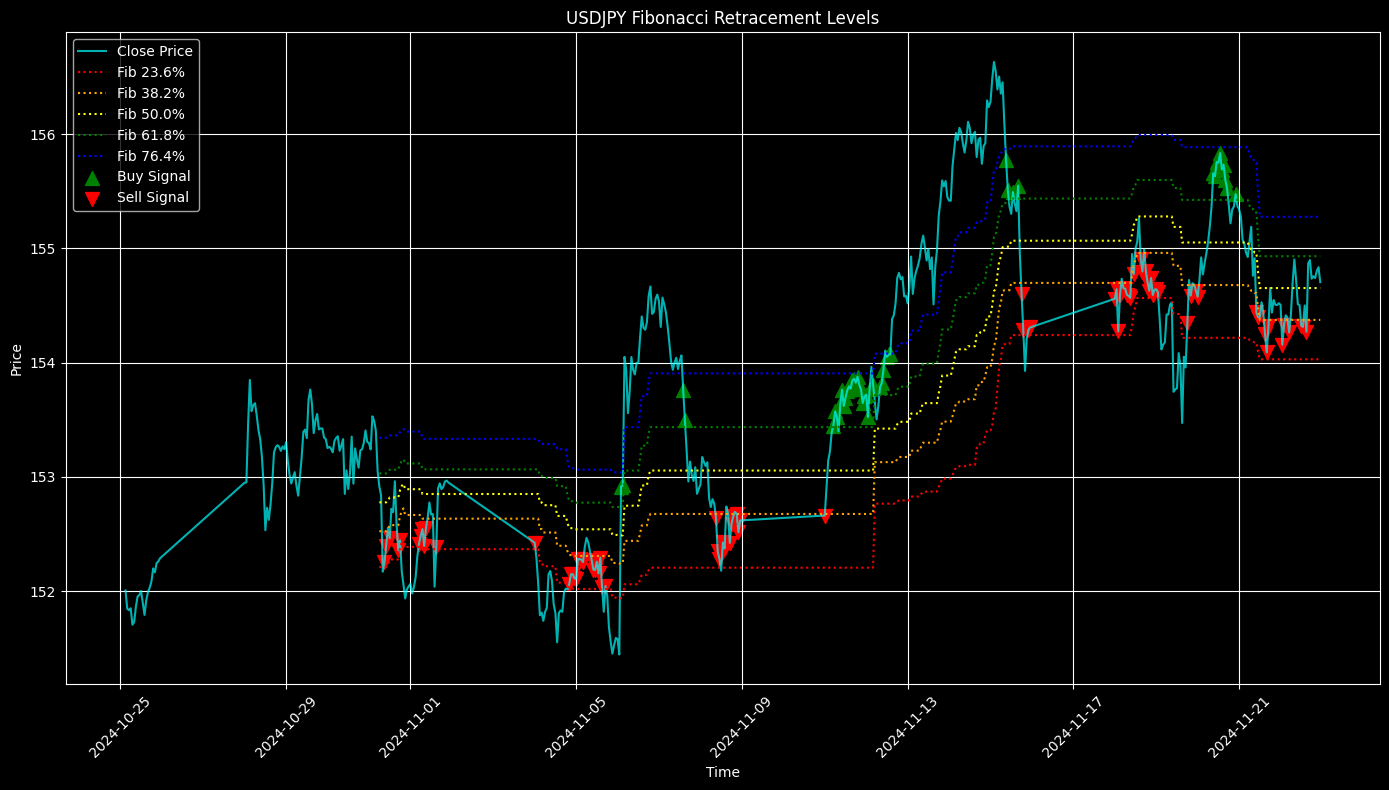

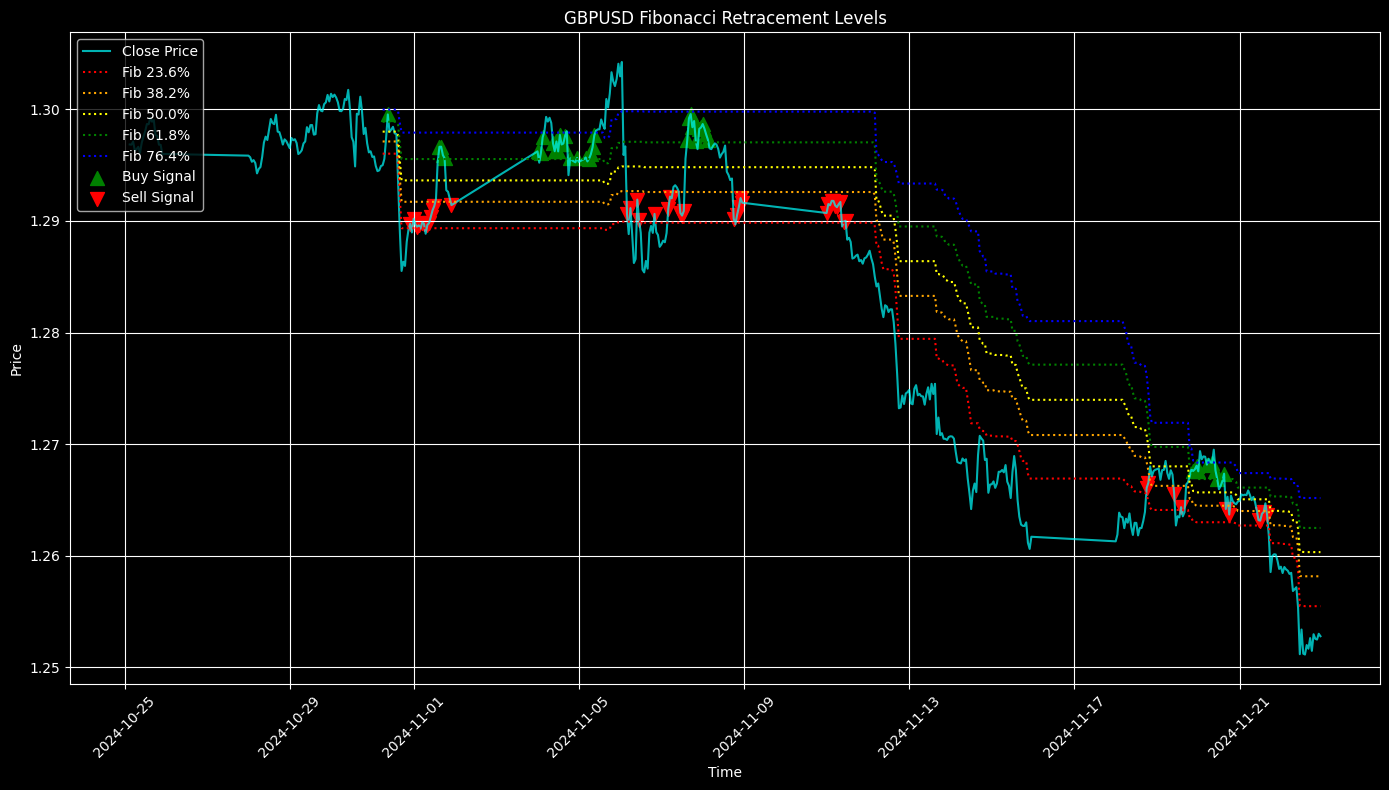

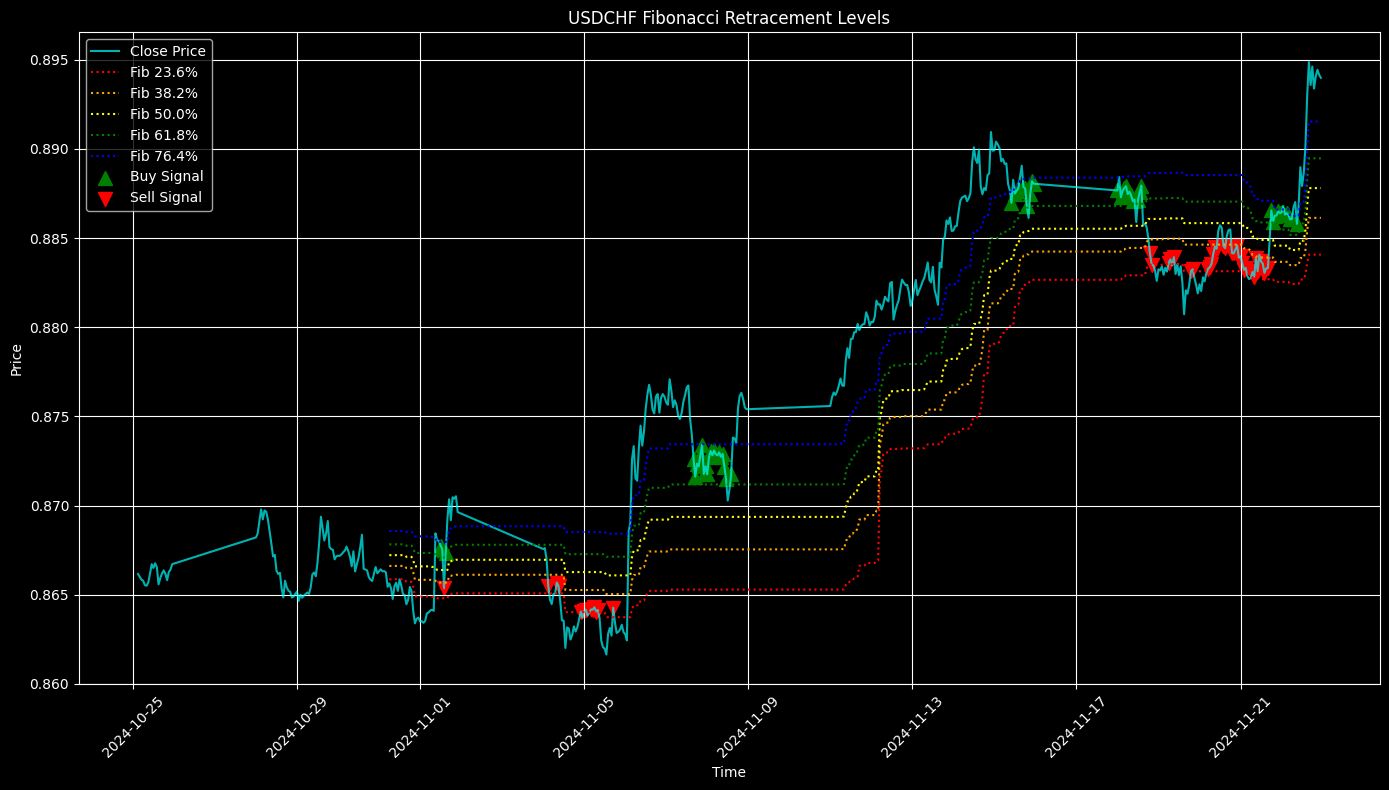

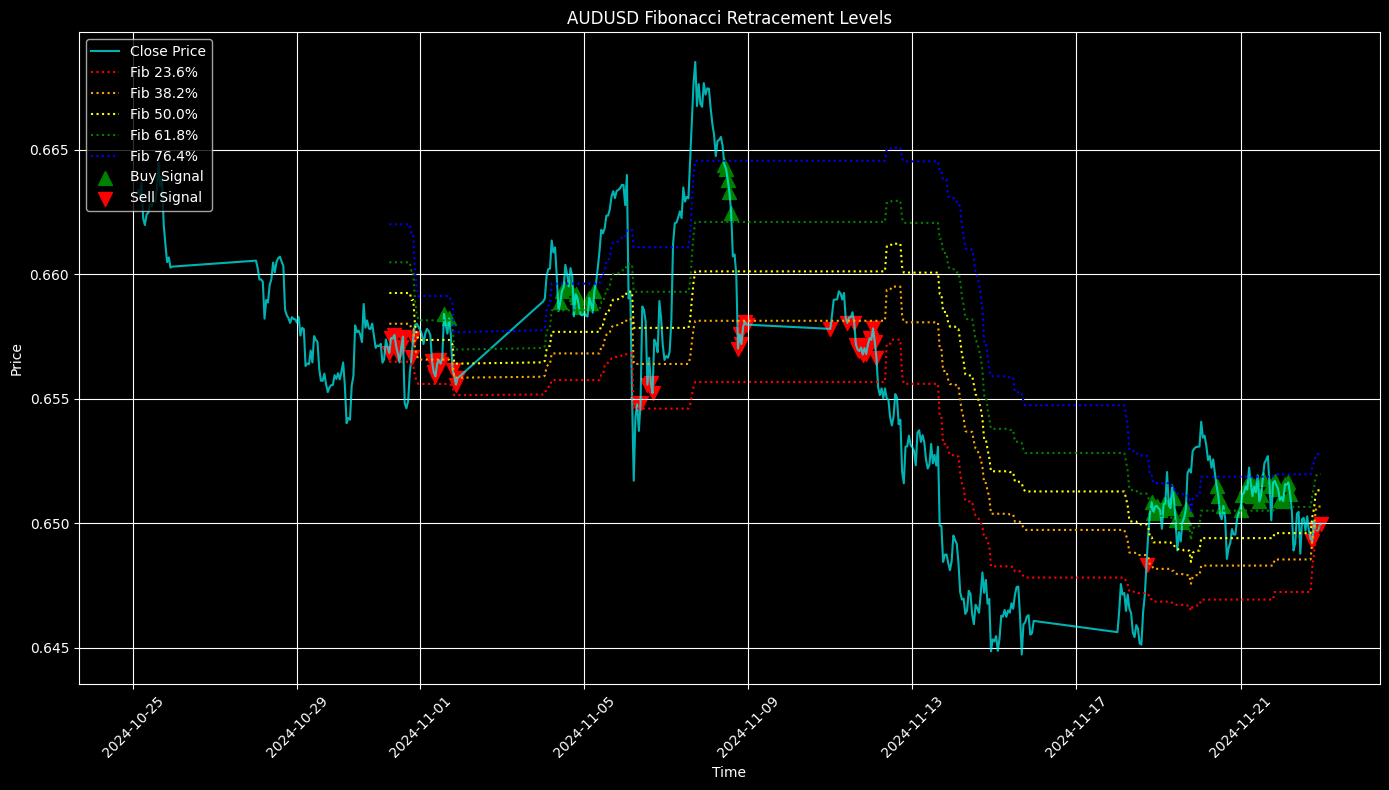

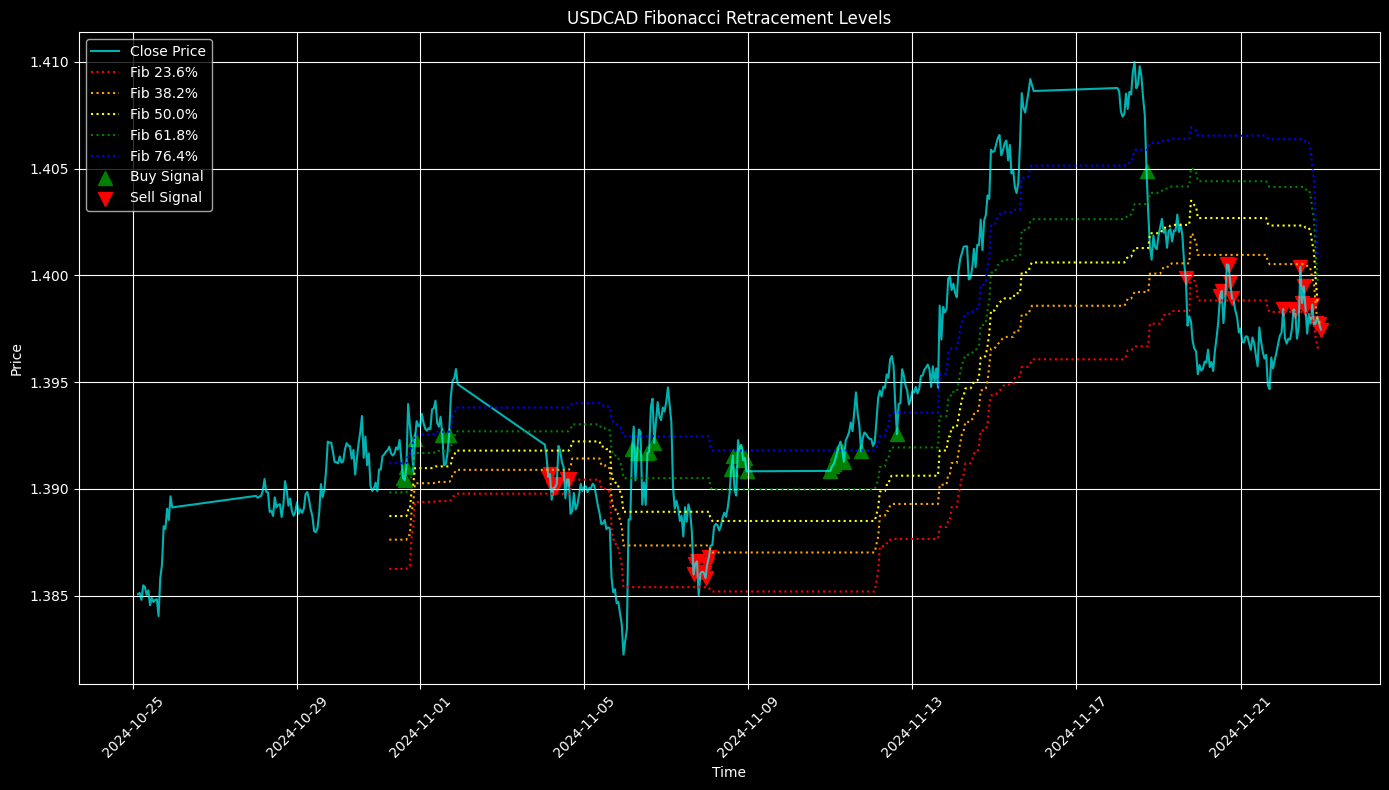

In [13]:
# Function to calculate Fibonacci retracement levels
def calculate_fibonacci_levels(data, lookback_period=100):
    # Find recent high and low over the lookback period
    recent_high = data['close'].rolling(window=lookback_period).max()
    recent_low = data['close'].rolling(window=lookback_period).min()

    # Calculate Fibonacci levels based on recent high and low
    data['Fib_23.6'] = recent_low + (recent_high - recent_low) * 0.236
    data['Fib_38.2'] = recent_low + (recent_high - recent_low) * 0.382
    data['Fib_50.0'] = recent_low + (recent_high - recent_low) * 0.5
    data['Fib_61.8'] = recent_low + (recent_high - recent_low) * 0.618
    data['Fib_76.4'] = recent_low + (recent_high - recent_low) * 0.764
    return data

# Set up Fibonacci retracement levels and signals
for pair, data in forex_data.items():
    data = calculate_fibonacci_levels(data)
    # Define buy/sell signals based on price crossing Fibonacci levels
    data['Buy_Signal'] = (data['close'] < data['Fib_76.4']) & (data['close'] > data['Fib_61.8'])
    data['Sell_Signal'] = (data['close'] > data['Fib_23.6']) & (data['close'] < data['Fib_38.2'])

# Function to plot each Forex pair with Fibonacci retracement levels and signals
def plot_fibonacci_retracement(df, pair):
    pair_data = df[df['pair'] == pair]

    # Set up the plot with a black background
    plt.style.use('dark_background')
    plt.figure(figsize=(14, 8))

    # Plot close price
    plt.plot(pair_data['time'], pair_data['close'], label='Close Price', color='cyan', alpha=0.7)

    # Plot Fibonacci levels
    plt.plot(pair_data['time'], pair_data['Fib_23.6'], label='Fib 23.6%', color='red', linestyle=':')
    plt.plot(pair_data['time'], pair_data['Fib_38.2'], label='Fib 38.2%', color='orange', linestyle=':')
    plt.plot(pair_data['time'], pair_data['Fib_50.0'], label='Fib 50.0%', color='yellow', linestyle=':')
    plt.plot(pair_data['time'], pair_data['Fib_61.8'], label='Fib 61.8%', color='green', linestyle=':')
    plt.plot(pair_data['time'], pair_data['Fib_76.4'], label='Fib 76.4%', color='blue', linestyle=':')

    # Mark Buy and Sell signals
    buy_signals = pair_data[pair_data['Buy_Signal']]
    sell_signals = pair_data[pair_data['Sell_Signal']]
    plt.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    # Customize the plot
    plt.title(f'{pair} Fibonacci Retracement Levels')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Consolidate the data into a single DataFrame for plotting
all_data = []
for pair, data in forex_data.items():
    data['pair'] = pair  # Add pair identifier
    all_data.append(data)
df = pd.concat(all_data, ignore_index=True)

# Plot Fibonacci retracement strategy for each Forex pair
for pair in df['pair'].unique():
    plot_fibonacci_retracement(df, pair)

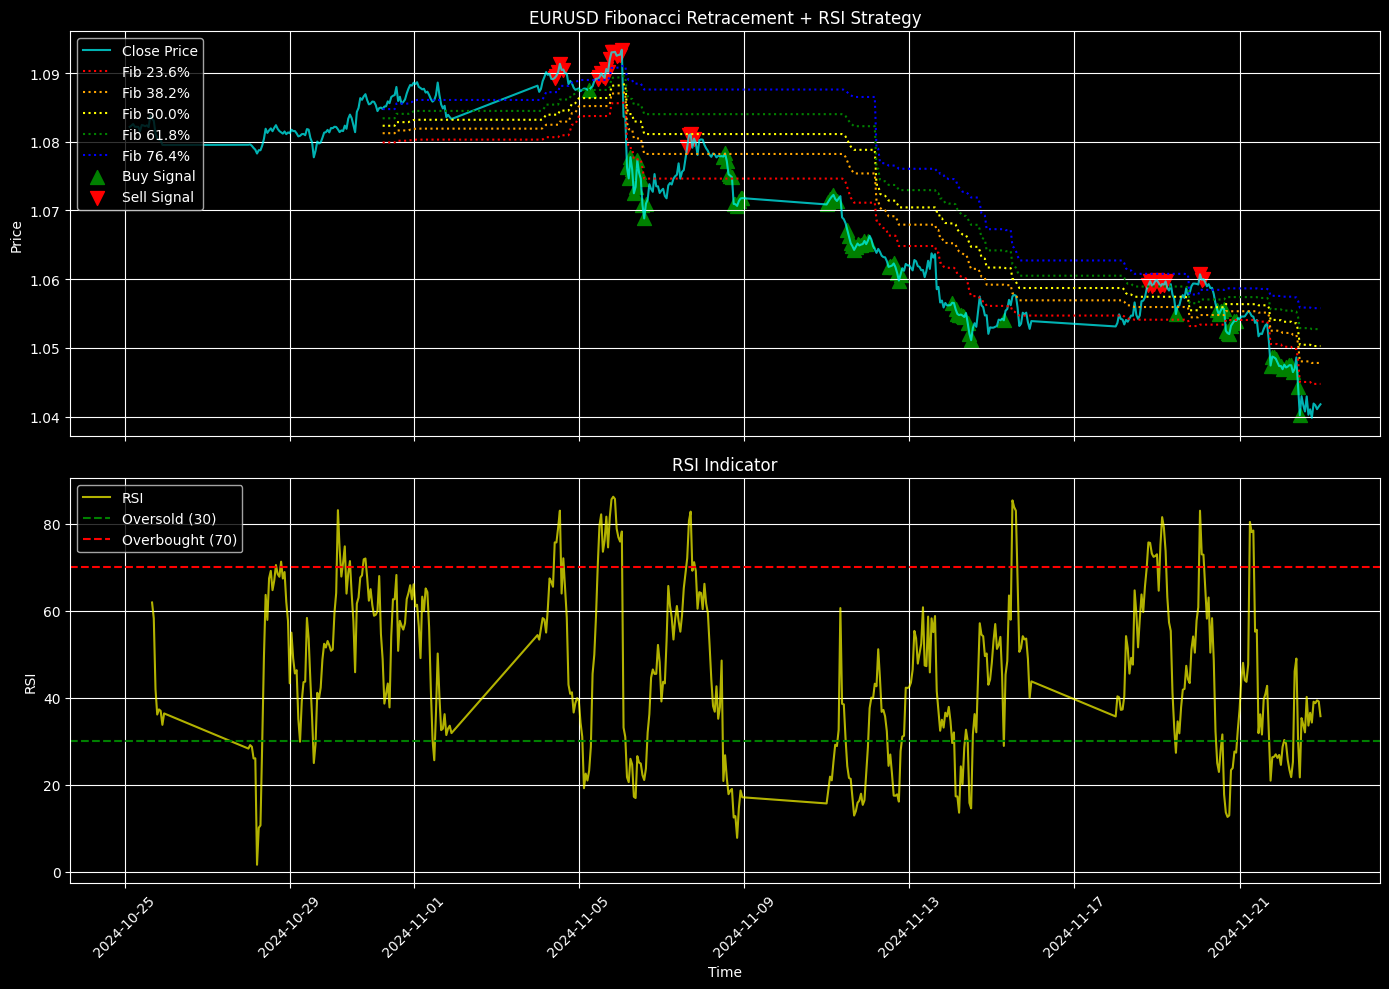

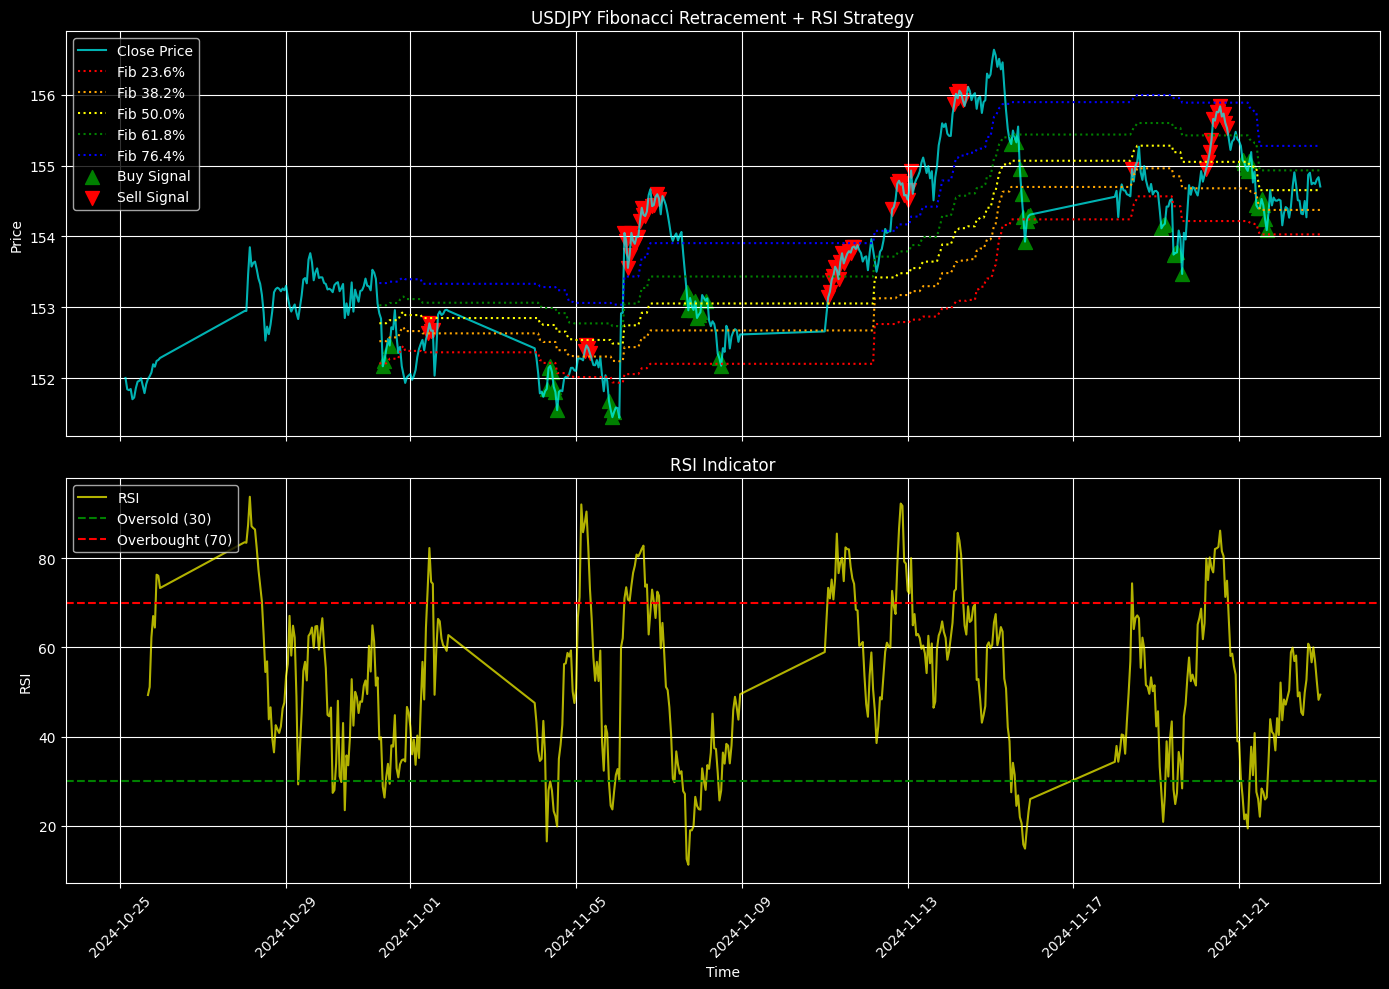

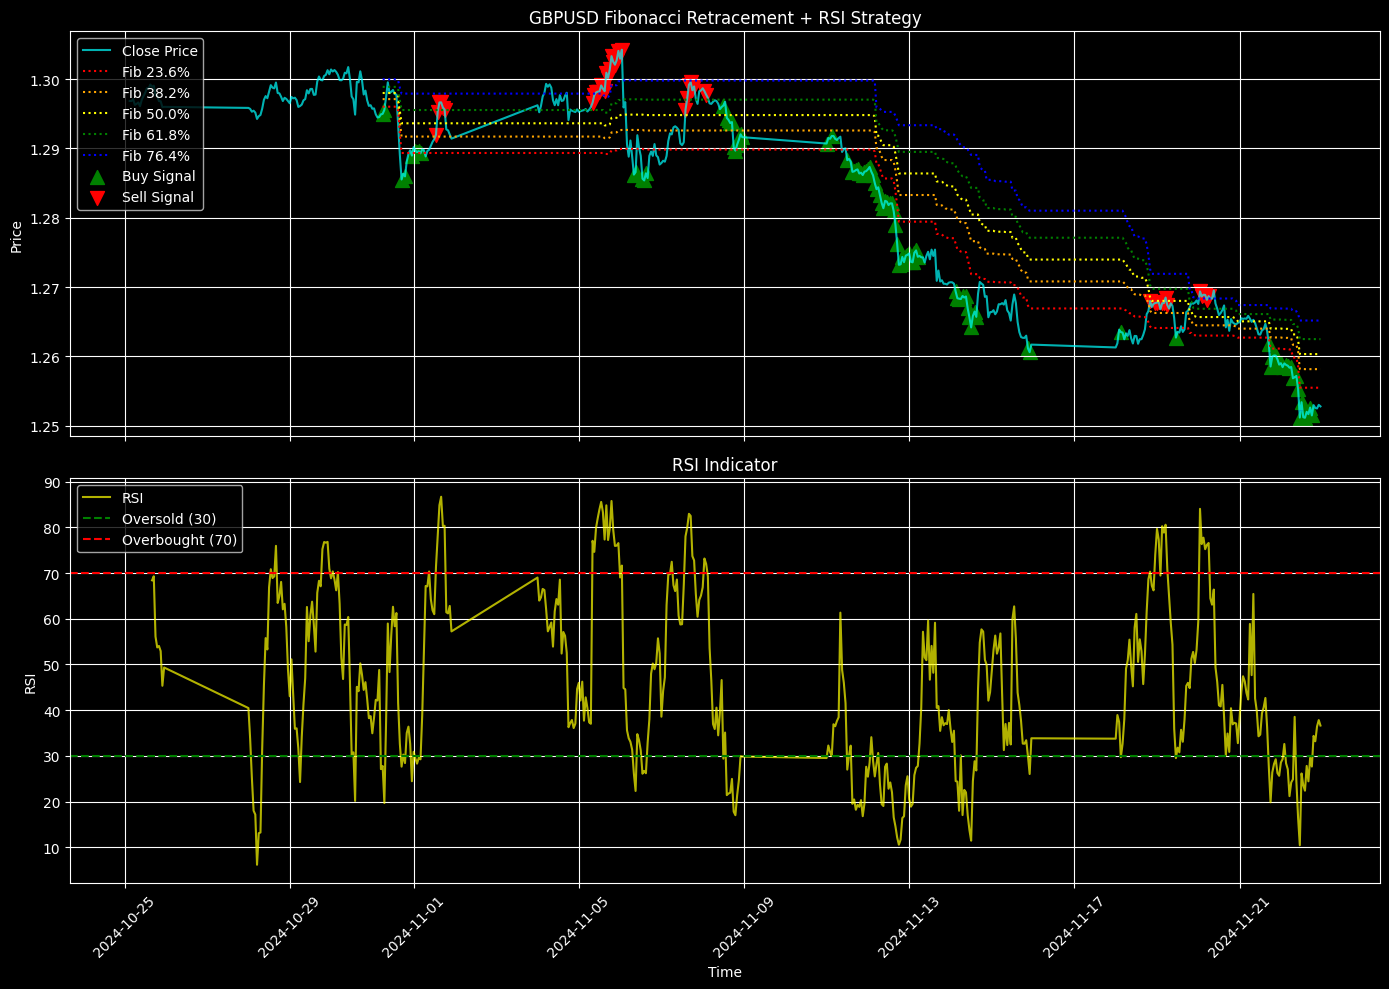

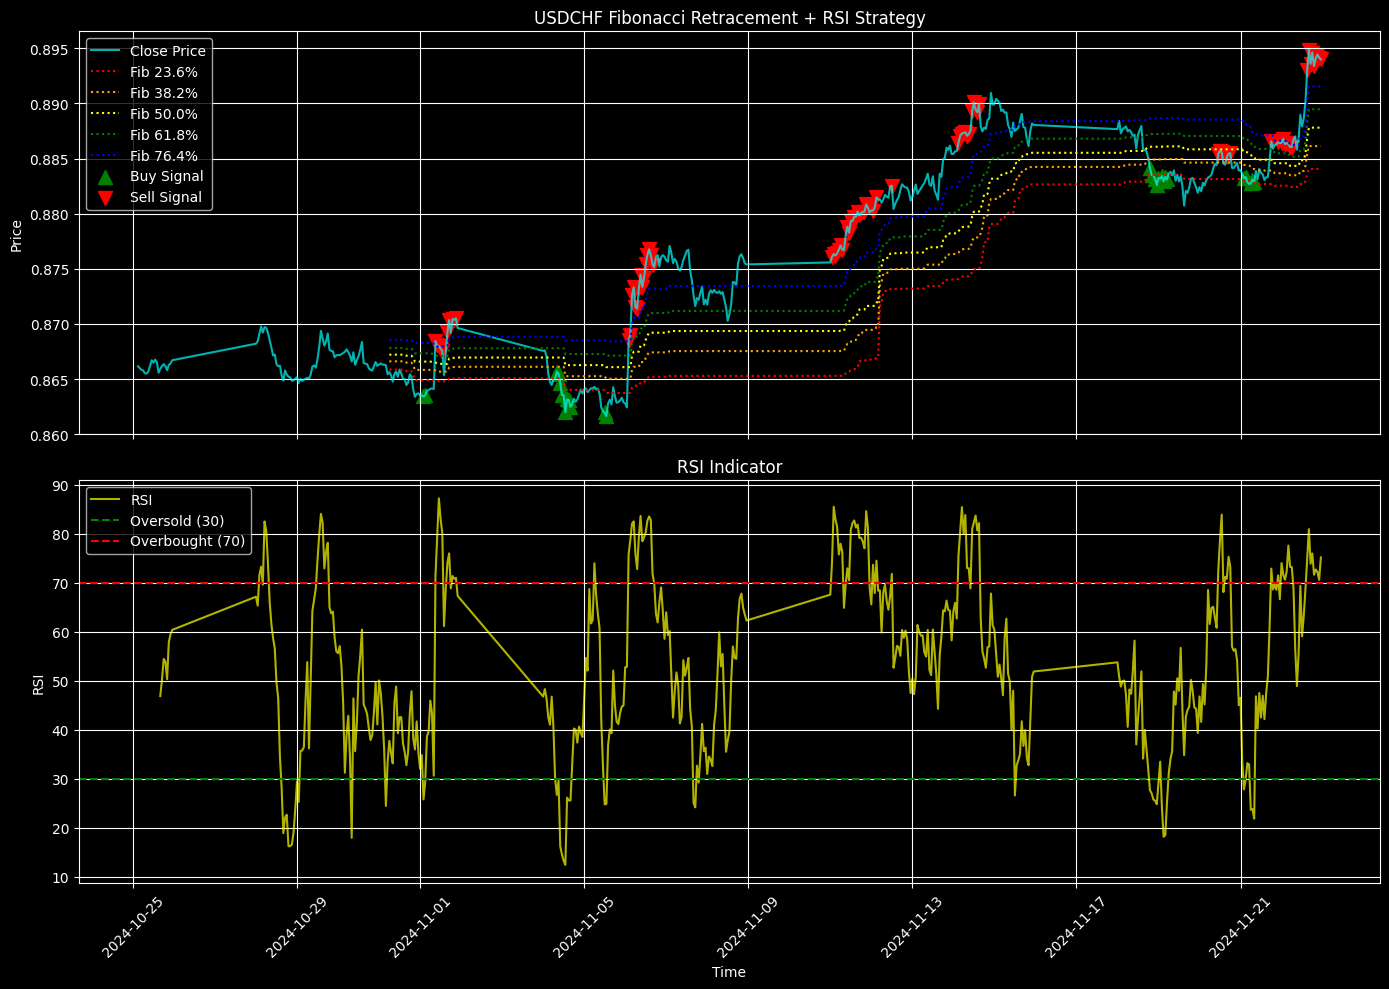

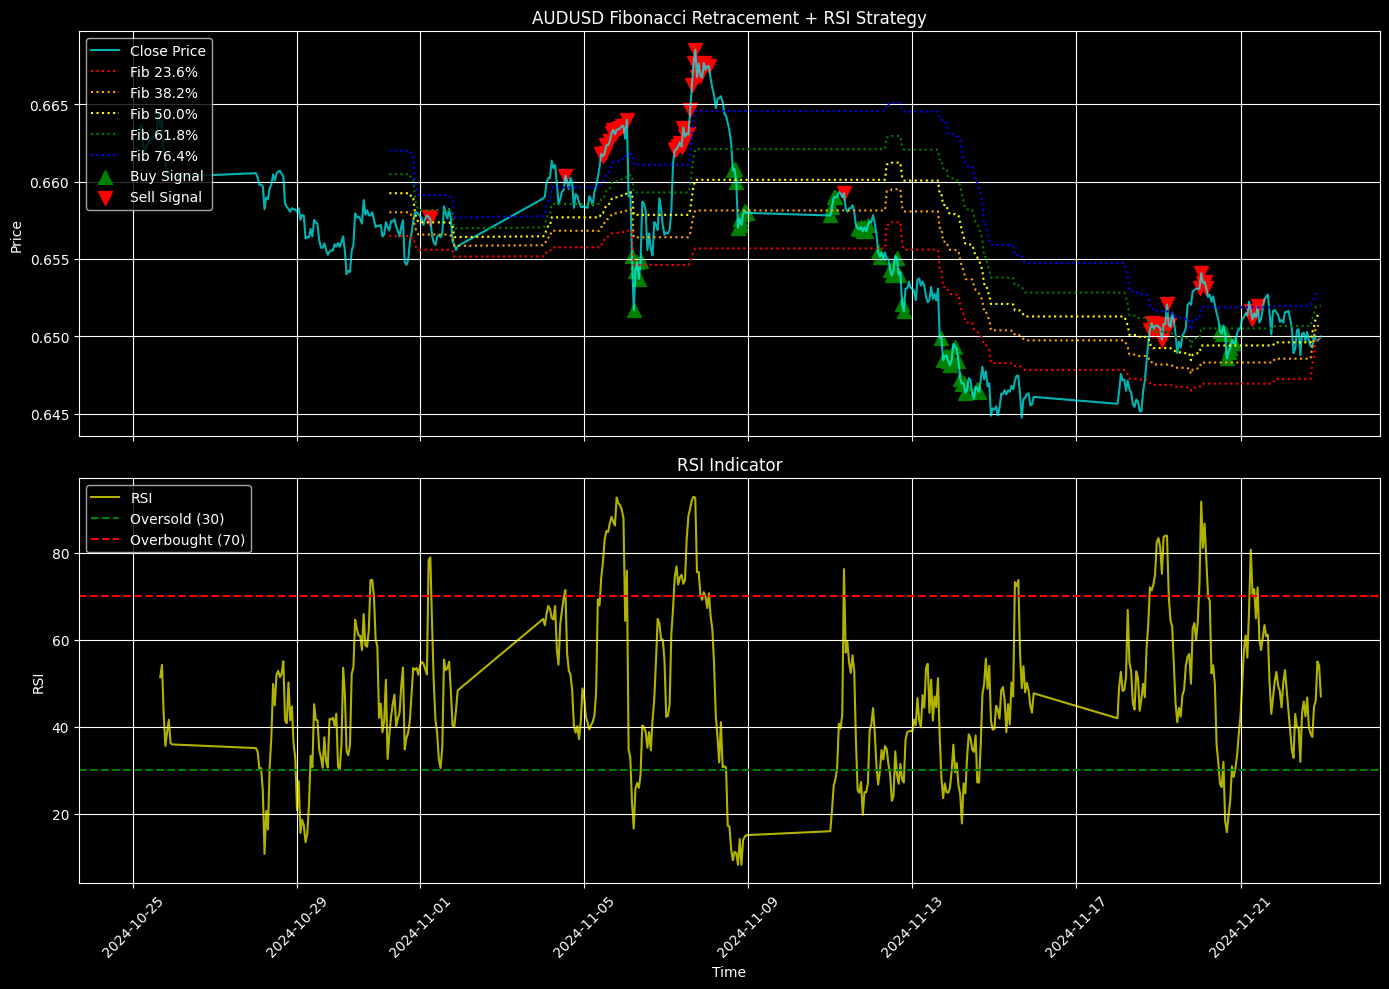

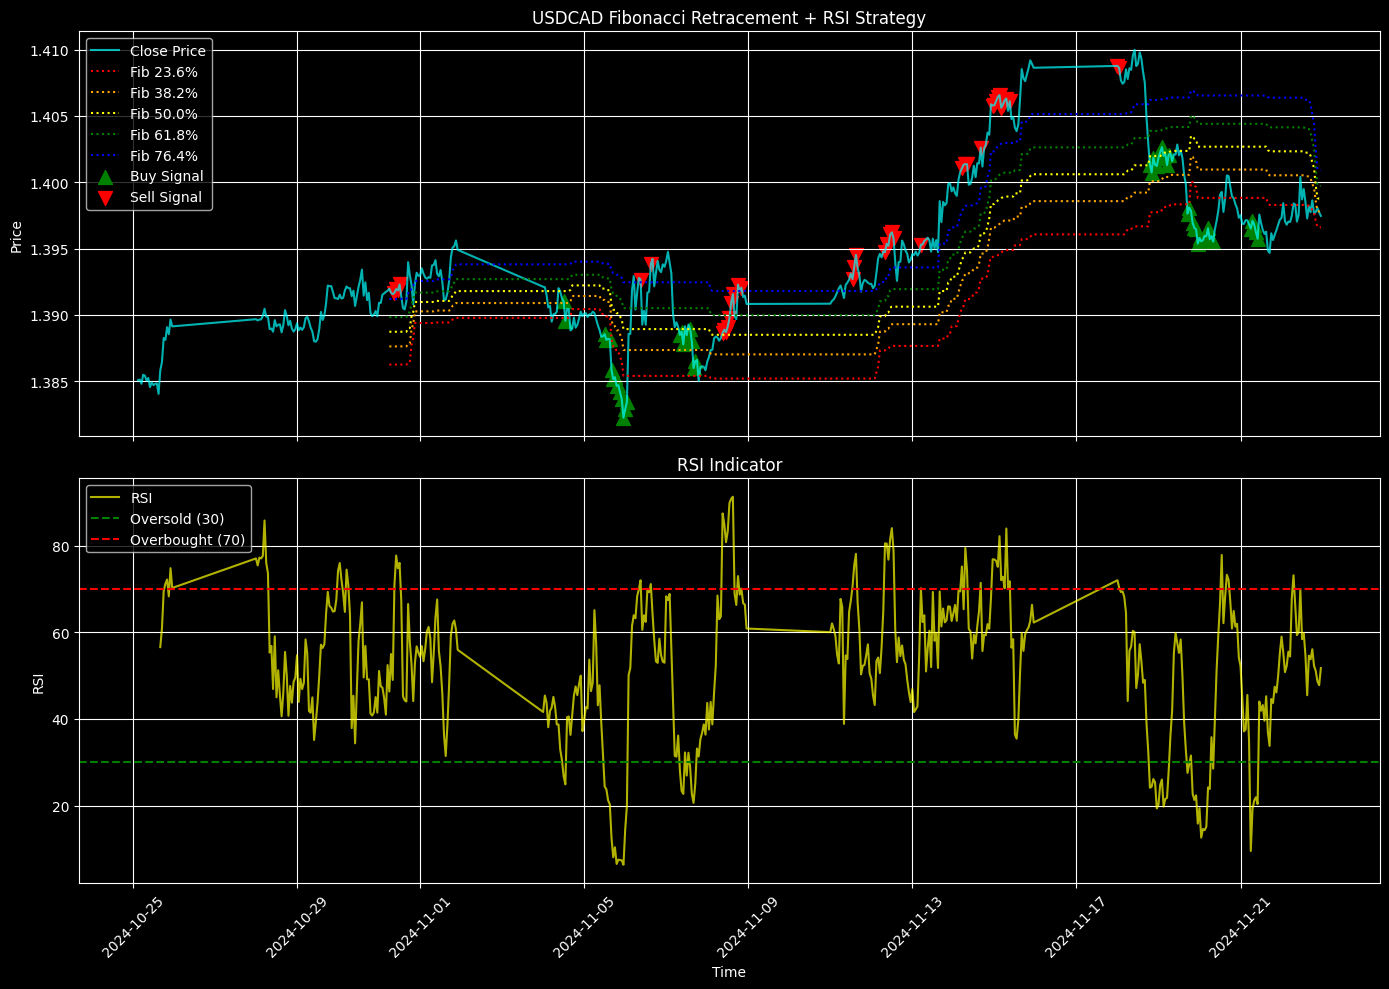

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate Fibonacci retracement levels
def calculate_fibonacci_levels(data, lookback_period=100):
    recent_high = data['close'].rolling(window=lookback_period).max()
    recent_low = data['close'].rolling(window=lookback_period).min()
    data['Fib_23.6'] = recent_low + (recent_high - recent_low) * 0.236
    data['Fib_38.2'] = recent_low + (recent_high - recent_low) * 0.382
    data['Fib_50.0'] = recent_low + (recent_high - recent_low) * 0.5
    data['Fib_61.8'] = recent_low + (recent_high - recent_low) * 0.618
    data['Fib_76.4'] = recent_low + (recent_high - recent_low) * 0.764
    return data

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Setting up Fibonacci levels and RSI for signals
for pair, data in forex_data.items():
    data = calculate_fibonacci_levels(data)
    data['RSI'] = calculate_rsi(data)
    
    # Define buy/sell signals based on Fibonacci levels and RSI
    data['Buy_Signal'] = (data['RSI'] < 30) & (data['close'] < data['Fib_61.8'])  # Buy at 61.8% retracement with RSI < 30
    data['Sell_Signal'] = (data['RSI'] > 70) & (data['close'] > data['Fib_38.2'])  # Sell at 38.2% retracement with RSI > 70

# Plotting function for each Forex pair with Fibonacci + RSI strategy
def plot_fibonacci_rsi(df, pair):
    pair_data = df[df['pair'] == pair]

    # Set up the plot with a black background
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot close price with Fibonacci retracement levels
    ax1.plot(pair_data['time'], pair_data['close'], label='Close Price', color='cyan', alpha=0.7)
    ax1.plot(pair_data['time'], pair_data['Fib_23.6'], label='Fib 23.6%', color='red', linestyle=':')
    ax1.plot(pair_data['time'], pair_data['Fib_38.2'], label='Fib 38.2%', color='orange', linestyle=':')
    ax1.plot(pair_data['time'], pair_data['Fib_50.0'], label='Fib 50.0%', color='yellow', linestyle=':')
    ax1.plot(pair_data['time'], pair_data['Fib_61.8'], label='Fib 61.8%', color='green', linestyle=':')
    ax1.plot(pair_data['time'], pair_data['Fib_76.4'], label='Fib 76.4%', color='blue', linestyle=':')

    # Mark Buy and Sell signals
    buy_signals = pair_data[pair_data['Buy_Signal']]
    sell_signals = pair_data[pair_data['Sell_Signal']]
    ax1.scatter(buy_signals['time'], buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    ax1.scatter(sell_signals['time'], sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    # Customize the price plot
    ax1.set_title(f'{pair} Fibonacci Retracement + RSI Strategy')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot RSI on a secondary axis
    ax2.plot(pair_data['time'], pair_data['RSI'], label='RSI', color='yellow', alpha=0.7)
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    
    # Customize the RSI plot
    ax2.set_title('RSI Indicator')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Consolidate the data into a single DataFrame for plotting
all_data = []
for pair, data in forex_data.items():
    data['pair'] = pair  # Add pair identifier
    all_data.append(data)
df = pd.concat(all_data, ignore_index=True)

# Plot Fibonacci + RSI strategy for each Forex pair
for pair in df['pair'].unique():
    plot_fibonacci_rsi(df, pair)

In [15]:
import pandas as pd

# Define parameters for backtesting
initial_balance = 10000  # Starting balance in USD
balance = initial_balance
position = None  # Tracks if a position is open
trade_log = []  # Stores trade details
risk_per_trade = 0.02  # Risk 2% of the balance per trade

# Run backtest
for i in range(1, len(df)):
    row = df.iloc[i]
    previous_row = df.iloc[i - 1]

    # Check buy conditions
    if row['Buy_Signal'] and position is None:
        entry_price = row['close']
        position = 'long'
        trade_log.append({
            'Type': 'Buy',
            'Entry Price': entry_price,
            'Entry Time': row['time'],
            'Size': balance * risk_per_trade / entry_price
        })

    # Check sell conditions if a long position is open
    elif row['Sell_Signal'] and position == 'long':
        exit_price = row['close']
        trade_log[-1]['Exit Price'] = exit_price
        trade_log[-1]['Exit Time'] = row['time']
        trade_log[-1]['Profit'] = (exit_price - trade_log[-1]['Entry Price']) * trade_log[-1]['Size']
        balance += trade_log[-1]['Profit']
        position = None

# Convert trade log to DataFrame for analysis
trades_df = pd.DataFrame(trade_log)

# Calculate performance metrics
total_profit = trades_df['Profit'].sum()
win_rate = len(trades_df[trades_df['Profit'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0
max_drawdown = (initial_balance - balance) / initial_balance if balance < initial_balance else 0
sharpe_ratio = (trades_df['Profit'].mean() / trades_df['Profit'].std()) * (252 ** 0.5) if len(trades_df) > 1 else 0

# Display results
print(f"Total Profit: ${total_profit:.2f}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Profit: $27728.75
Win Rate: 64.00%
Max Drawdown: 0.00%
Sharpe Ratio: 3.12


In [16]:
trades_df

Type  Entry Price          Entry Time         Size  Exit Price  \
0   Buy      1.08752 2024-11-05 06:00:00   183.904664     1.08917   
1   Buy      1.07625 2024-11-06 04:00:00   185.836069     1.07923   
2   Buy      1.07784 2024-11-08 12:00:00   185.572204     1.05909   
3   Buy      1.05492 2024-11-19 11:00:00   189.538121     1.06070   
4   Buy      1.05554 2024-11-20 11:00:00   189.447549   152.64200   
5   Buy    151.85200 2024-11-04 07:00:00     5.099196   152.38400   
6   Buy    151.68300 2024-11-05 19:00:00     5.105235   154.05000   
7   Buy    153.22200 2024-11-07 16:00:00     5.055534   153.14300   
8   Buy    155.30200 2024-11-15 12:00:00     4.987773   154.95100   
9   Buy    154.11500 2024-11-19 03:00:00     5.025962   154.95400   
10  Buy    155.07800 2024-11-21 02:00:00     4.995295     1.29199   
11  Buy      1.28623 2024-11-06 08:00:00   590.326980     1.29558   
12  Buy      1.29619 2024-11-08 12:00:00   585.876039     1.26801   
13  Buy      1.26272 2024-11-19 11:00:00   601.143930     1.26938   
14  Buy      1.26176 2024-11-21 17:00:00   601.664766     0.86844   
15  Buy      0.86568 2024-11-04 08:00:00   871.480917     0.86851   
16  Buy      0.88415 2024-11-18 19:00:00   853.331364     0.88542   
17  Buy      0.88322 2024-11-21 02:00:00   854.254433     0.88655   
18  Buy      0.65517 2024-11-06 04:00:00  1151.688102     0.66205   
19  Buy      0.66072 2024-11-08 15:00:00  1142.253853     0.65925   
20  Buy      0.65698 2024-11-11 16:00:00  1148.705263     0.65041   
21  Buy      0.65033 2024-11-20 12:00:00  1160.219341     0.65162   
22  Buy      1.39101 2024-11-04 12:00:00   542.451440     1.39266   
23  Buy      1.38849 2024-11-07 08:00:00   543.448839     1.38865   
24  Buy      1.40133 2024-11-18 19:00:00   538.470608         NaN   

             Exit Time        Profit  
0  2024-11-05 11:00:00      0.303443  
1  2024-11-07 15:00:00      0.553791  
2  2024-11-18 19:00:00     -3.479479  
3  2024-11-20 01:00:00      1.095530  
4  2024-11-01 10:00:00  28717.683286  
5  2024-11-05 05:00:00      2.712772  
6  2024-11-06 04:00:00     12.084092  
7  2024-11-11 02:00:00     -0.399387  
8  2024-11-18 10:00:00     -1.750708  
9  2024-11-20 05:00:00      4.216782  
10 2024-11-01 13:00:00   -768.206531  
11 2024-11-07 14:00:00      5.519557  
12 2024-11-18 20:00:00    -16.509987  
13 2024-11-20 01:00:00      4.003619  
14 2024-11-01 09:00:00   -236.646786  
15 2024-11-06 02:00:00      2.466291  
16 2024-11-20 11:00:00      1.083731  
17 2024-11-21 18:00:00      2.844667  
18 2024-11-07 05:00:00      7.923614  
19 2024-11-11 08:00:00     -1.679113  
20 2024-11-18 19:00:00     -7.546994  
21 2024-11-21 06:00:00      1.496683  
22 2024-11-06 09:00:00      0.895045  
23 2024-11-08 09:00:00      0.086952  
24                 NaT           NaN

In [17]:
pair_data

time     open     high      low    close  tick_volume  \
0   2024-10-25 03:00:00  1.38536  1.38543  1.38498  1.38507         1362   
1   2024-10-25 04:00:00  1.38511  1.38523  1.38479  1.38512         1411   
2   2024-10-25 05:00:00  1.38512  1.38540  1.38473  1.38480         1412   
3   2024-10-25 06:00:00  1.38480  1.38560  1.38480  1.38548         1018   
4   2024-10-25 07:00:00  1.38548  1.38557  1.38529  1.38541          731   
..                  ...      ...      ...      ...      ...          ...   
495 2024-11-22 19:00:00  1.39862  1.39862  1.39759  1.39764         1833   
496 2024-11-22 20:00:00  1.39766  1.39799  1.39709  1.39776         1525   
497 2024-11-22 21:00:00  1.39777  1.39814  1.39766  1.39806         1463   
498 2024-11-22 22:00:00  1.39806  1.39878  1.39761  1.39773         1373   
499 2024-11-22 23:00:00  1.39774  1.39828  1.39742  1.39746         1209   

     spread  real_volume   returns    pair  volatility     MA_50    MA_200  \
0         5            0       NaN  USDCAD         NaN       NaN       NaN   
1         5            0  0.000036  USDCAD         NaN       NaN       NaN   
2         5            0 -0.000231  USDCAD         NaN       NaN       NaN   
3         5            0  0.000491  USDCAD         NaN       NaN       NaN   
4         5            0 -0.000051  USDCAD         NaN       NaN       NaN   
..      ...          ...       ...     ...         ...       ...       ...   
495       5            0 -0.000708  USDCAD    0.000789  1.397313  1.400126   
496       6            0  0.000086  USDCAD    0.000789  1.397275  1.400134   
497       6            0  0.000215  USDCAD    0.000770  1.397257  1.400145   
498       6            0 -0.000236  USDCAD    0.000738  1.397236  1.400164   
499       3            0 -0.000193  USDCAD    0.000738  1.397218  1.400189   

     trend  Buy_Signal  Sell_Signal  
0    False       False        False  
1    False       False        False  
2    False       False        False  
3    False       False        False  
4    False       False        False  
..     ...         ...          ...  
495  False       False        False  
496  False       False        False  
497  False       False        False  
498  False       False        False  
499  False       False        False  

[500 rows x 16 columns]

In [18]:
df

time     open     high      low    close  tick_volume  \
0    2024-10-25 03:00:00  1.08239  1.08249  1.08200  1.08216         1040   
1    2024-10-25 04:00:00  1.08217  1.08248  1.08200  1.08234         1003   
2    2024-10-25 05:00:00  1.08233  1.08274  1.08227  1.08258          825   
3    2024-10-25 06:00:00  1.08258  1.08258  1.08201  1.08216          610   
4    2024-10-25 07:00:00  1.08217  1.08230  1.08205  1.08218          637   
...                  ...      ...      ...      ...      ...          ...   
2995 2024-11-22 19:00:00  1.39862  1.39862  1.39759  1.39764         1833   
2996 2024-11-22 20:00:00  1.39766  1.39799  1.39709  1.39776         1525   
2997 2024-11-22 21:00:00  1.39777  1.39814  1.39766  1.39806         1463   
2998 2024-11-22 22:00:00  1.39806  1.39878  1.39761  1.39773         1373   
2999 2024-11-22 23:00:00  1.39774  1.39828  1.39742  1.39746         1209   

      spread  real_volume   returns    pair  ...  Buy_Signal  Sell_Signal  \
0          3            0       NaN  EURUSD  ...       False        False   
1          4            0  0.000166  EURUSD  ...       False        False   
2          0            0  0.000222  EURUSD  ...       False        False   
3          1            0 -0.000388  EURUSD  ...       False        False   
4          0            0  0.000018  EURUSD  ...       False        False   
...      ...          ...       ...     ...  ...         ...          ...   
2995       5            0 -0.000708  USDCAD  ...       False        False   
2996       6            0  0.000086  USDCAD  ...       False        False   
2997       6            0  0.000215  USDCAD  ...       False        False   
2998       6            0 -0.000236  USDCAD  ...       False        False   
2999       3            0 -0.000193  USDCAD  ...       False        False   

            MA  Upper_Band  Lower_Band  Fib_23.6  Fib_38.2  Fib_50.0  \
0          NaN         NaN         NaN       NaN       NaN       NaN   
1          NaN         NaN         NaN       NaN       NaN       NaN   
2          NaN         NaN         NaN       NaN       NaN       NaN   
3          NaN         NaN         NaN       NaN       NaN       NaN   
4          NaN         NaN         NaN       NaN       NaN       NaN   
...        ...         ...         ...       ...       ...       ...   
2995  1.397945    1.399802    1.396088  1.397698  1.399571  1.401085   
2996  1.397968    1.399803    1.396132  1.397084  1.398578  1.399785   
2997  1.397949    1.399773    1.396126  1.396624  1.397833  1.398810   
2998  1.397983    1.399762    1.396204  1.396598  1.397791  1.398755   
2999  1.398016    1.399726    1.396306  1.396598  1.397791  1.398755   

      Fib_61.8  Fib_76.4  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
2995  1.402599  1.404472  
2996  1.400992  1.402486  
2997  1.399787  1.400996  
2998  1.399719  1.400912  
2999  1.399719  1.400912  

[3000 rows x 21 columns]